In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
# Import all the necessary modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge
from sklearn.manifold import TSNE

from scipy.stats import gaussian_kde

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



#### Opening the dataset

In [ ]:
# Define the base directory and file names
base_dir = 'data'
train_file = 'train.csv'
test_file = 'test.csv'

# Construct the full file paths
train_file_path = os.path.join(base_dir, train_file)
test_file_path = os.path.join(base_dir, test_file)

# Read the train and test csv to dataframe using pandas
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

#### Basic exploration of the dataset

In [ ]:
# Finding the number of train and test datapoints and number of columns
print("Total training data points:", len(train_df))
print("Total test data points:", len(test_df))
print("Column length (train):", len(train_df.columns),", Column length (test):", len(test_df.columns))

# Peek at the datapoint
print("\n\n Peeking at the data points:")
train_df.head(10)

Total training data points: 1460
Total test data points: 1459
Column length (train): 81 , Column length (test): 80


 Peeking at the data points:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [ ]:
# Finding the datatypes of each of the features
print("Datatypes of each column:")
print('----------------------------')
print(train_df.dtypes)

# Find the number of different datatypes
print("\n\nNumber of each data type:")
print("----------------------------")
train_df.dtypes.value_counts()

Datatypes of each column:
----------------------------
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


Number of each data type:
----------------------------


object     43
int64      35
float64     3
Name: count, dtype: int64

In [ ]:
# Find if there are duplicates in the dataset
print("Duplicated data in training set:", len(train_df[train_df.duplicated()]))
train_df = train_df[~train_df.duplicated()]

Duplicated data in training set: 0


In [ ]:
# Seperating the categorical and non categorical data to make the analysis seperately
# Find only non categorical features or features that are already encoded
train_df_non_categorical = train_df.select_dtypes(exclude = 'object')
test_df_non_categorical = test_df.select_dtypes(exclude = 'object')

# Find the categorical data types except the ones that are already encoded
train_df_categorical = train_df.select_dtypes(include = 'object')
test_df_categorical = test_df.select_dtypes(include = 'object')
features_by_n_categories = [(column, train_df_categorical[column].nunique()) for column in train_df_categorical.columns]

# Print the number of categories in each categorical feature(without the Nan)
features_by_n_categories

[('MSZoning', 5),
 ('Street', 2),
 ('Alley', 2),
 ('LotShape', 4),
 ('LandContour', 4),
 ('Utilities', 2),
 ('LotConfig', 5),
 ('LandSlope', 3),
 ('Neighborhood', 25),
 ('Condition1', 9),
 ('Condition2', 8),
 ('BldgType', 5),
 ('HouseStyle', 8),
 ('RoofStyle', 6),
 ('RoofMatl', 8),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('MasVnrType', 3),
 ('ExterQual', 4),
 ('ExterCond', 5),
 ('Foundation', 6),
 ('BsmtQual', 4),
 ('BsmtCond', 4),
 ('BsmtExposure', 4),
 ('BsmtFinType1', 6),
 ('BsmtFinType2', 6),
 ('Heating', 6),
 ('HeatingQC', 5),
 ('CentralAir', 2),
 ('Electrical', 5),
 ('KitchenQual', 4),
 ('Functional', 7),
 ('FireplaceQu', 5),
 ('GarageType', 6),
 ('GarageFinish', 3),
 ('GarageQual', 5),
 ('GarageCond', 5),
 ('PavedDrive', 3),
 ('PoolQC', 3),
 ('Fence', 4),
 ('MiscFeature', 4),
 ('SaleType', 9),
 ('SaleCondition', 6)]

In [ ]:
# Number of Nan in each column of categorical features
train_df_categorical.isna().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [ ]:
test_df_categorical.isna().sum()

MSZoning            4
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType        894
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinType2       42
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
KitchenQual         1
Functional          2
FireplaceQu       730
GarageType         76
GarageFinish       78
GarageQual         78
GarageCond         78
PavedDrive          0
PoolQC           1456
Fence            1169
MiscFeature      1408
SaleType            1
SaleCondition       0
dtype: int64

In [ ]:
# GarageCond and GarageQual are two different features
train_df_categorical[train_df_categorical['GarageCond'] != train_df_categorical['GarageQual']].loc[:,['GarageCond', 'GarageQual']].value_counts()

GarageCond  GarageQual
TA          Fa            24
Fa          TA            15
TA          Gd            10
Gd          TA             5
Po          Fa             4
TA          Ex             1
Name: count, dtype: int64

In [ ]:
# Data count in Electrical feature column
print(train_df_categorical['Electrical'].value_counts())

# There is actually a missing value in Electrical
# Replacing that with the most frequent data(mode) i.e. SBrkr
train_df_categorical['Electrical'].fillna(train_df_categorical['Electrical'].mode()[0], inplace = True)

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64


In [ ]:
# The datapoint that may or maynot have the basement
# No basement indicated in Basement Exposure but Average Basement Condition given for that point
print("Basement Condition present but No basement indicated in Basement Exposure:")
print(train_df_categorical['BsmtCond'][train_df_categorical['BsmtExposure'].isna()].dropna())

# No basement Type 2 but Good Basement Type 1
print("\n\nBasement Finish Type 1 present but no basement Finish Type 2:")
print(train_df_categorical['BsmtFinType1'][train_df_categorical['BsmtFinType2'].isna()].dropna())

Basement Condition present but No basement indicated in Basement Exposure:
948    TA
Name: BsmtCond, dtype: object


Basement Finish Type 1 present but no basement Finish Type 2:
332    GLQ
Name: BsmtFinType1, dtype: object


In [ ]:
# train_df_categorical.iloc[948,:], train_df_categorical.iloc[332,:]
# All the other columns(feature) that have "Nan" represent that the house has that feature as missing
# Also I have decided to ignore the inconsistency in Basement Features as it only affects 1 datapoint

# Fill all the "Nan" values with "NA" which representa an extra-category for that feature
train_df_categorical.fillna("NA", inplace = True)
features_by_n_categories = [(column, train_df_categorical[column].nunique()) for column in train_df_categorical.columns]

# Print the number of categories in each categorical feature(with the Extra NA type)
features_by_n_categories

[('MSZoning', 5),
 ('Street', 2),
 ('Alley', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('Utilities', 2),
 ('LotConfig', 5),
 ('LandSlope', 3),
 ('Neighborhood', 25),
 ('Condition1', 9),
 ('Condition2', 8),
 ('BldgType', 5),
 ('HouseStyle', 8),
 ('RoofStyle', 6),
 ('RoofMatl', 8),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('MasVnrType', 4),
 ('ExterQual', 4),
 ('ExterCond', 5),
 ('Foundation', 6),
 ('BsmtQual', 5),
 ('BsmtCond', 5),
 ('BsmtExposure', 5),
 ('BsmtFinType1', 7),
 ('BsmtFinType2', 7),
 ('Heating', 6),
 ('HeatingQC', 5),
 ('CentralAir', 2),
 ('Electrical', 5),
 ('KitchenQual', 4),
 ('Functional', 7),
 ('FireplaceQu', 6),
 ('GarageType', 7),
 ('GarageFinish', 4),
 ('GarageQual', 6),
 ('GarageCond', 6),
 ('PavedDrive', 3),
 ('PoolQC', 4),
 ('Fence', 5),
 ('MiscFeature', 5),
 ('SaleType', 9),
 ('SaleCondition', 6)]

In [ ]:
# For these columns replace the value with the mode from that feature in test set
# These are the features that have missing values in test but not in train
for col in ['MSZoning','Utilities', 'Exterior1st', 'Exterior2nd','KitchenQual', 'Functional', 'SaleType']:
  test_df_categorical[col].fillna(test_df_categorical[col].mode()[0], inplace = True)

In [ ]:
test_df_categorical.isna().sum()

MSZoning            0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        894
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinType2       42
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
KitchenQual         0
Functional          0
FireplaceQu       730
GarageType         76
GarageFinish       78
GarageQual         78
GarageCond         78
PavedDrive          0
PoolQC           1456
Fence            1169
MiscFeature      1408
SaleType            0
SaleCondition       0
dtype: int64

In [ ]:
test_df_categorical.fillna("NA", inplace = True)

In [ ]:
test_df_categorical.isna().sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

## Encoding and Analysis of Unencoded Features

1. Performing Ordinal Encoding to Selected Features

In [ ]:

# Create a new DataFrame with the same index as the original DataFrame
train_df_categorical_encoded = pd.DataFrame(index=train_df_categorical.index)
test_df_categorical_encoded = pd.DataFrame(index=test_df_categorical.index)


# Ordinal mapping for all the 'quality' related features
label_encoding_condition = {
    'NA': 0,
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
}
columns_with_5_grading = ['PoolQC', 'GarageCond','GarageQual','FireplaceQu','KitchenQual', 'HeatingQC',
                      'BsmtCond', 'BsmtQual','ExterCond','ExterQual']


# Assign the features to the encoded variable
for column in columns_with_5_grading:
  train_df_categorical_encoded[column] =  train_df_categorical[column].map(label_encoding_condition)

# Assign the features to the encoded variable(test)
for column in columns_with_5_grading:
  test_df_categorical_encoded[column] =  test_df_categorical[column].map(label_encoding_condition)


# Ordinal Encoding for fence
label_encoding_condition_fence = {
    'NA': 0,
    'MnWw': 1,
    'GdWo': 2,
    'MnPrv': 3,
    'GdPrv': 4,
}
train_df_categorical_encoded['Fence'] =  train_df_categorical['Fence'].map(label_encoding_condition_fence)
test_df_categorical_encoded['Fence'] =  test_df_categorical['Fence'].map(label_encoding_condition_fence)

# Ordinal Encoding for Basement Finish Type 1 and 2
label_encoding_condition_basement_finish = {
    'NA': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ':5,
    'GLQ':6
}
train_df_categorical_encoded['BsmtFinType1'] =  train_df_categorical['BsmtFinType1'].map(label_encoding_condition_basement_finish)
train_df_categorical_encoded['BsmtFinType2'] =  train_df_categorical['BsmtFinType2'].map(label_encoding_condition_basement_finish)
test_df_categorical_encoded['BsmtFinType1'] =  test_df_categorical['BsmtFinType1'].map(label_encoding_condition_basement_finish)
test_df_categorical_encoded['BsmtFinType2'] =  test_df_categorical['BsmtFinType2'].map(label_encoding_condition_basement_finish)


# Ordinal encoding the Basement Exposure
label_encoding_condition_basement_exposure = {
    'NA': 0,
    'No': 1,
    'Mn': 2,
    'Av': 3,
    'Gd': 4,
}
train_df_categorical_encoded['BsmtExposure'] =  train_df_categorical['BsmtExposure'].map(label_encoding_condition_basement_exposure)
test_df_categorical_encoded['BsmtExposure'] =  test_df_categorical['BsmtExposure'].map(label_encoding_condition_basement_exposure)

ordinal_encoding_columns = list(train_df_categorical_encoded.columns)
print()
print("The columns that are encoded ordinally:", ordinal_encoding_columns, "\nNumber:", len(ordinal_encoding_columns))


The columns that are encoded ordinally: ['PoolQC', 'GarageCond', 'GarageQual', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'Fence', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure'] 
Number: 14


2. Performing 1-Hot encoding to features that don't have ranking and have less than 10 categories(so that feature doesn't become too sparse)

In [ ]:
target_encoding_feature_names = [f_name for f_name, value in features_by_n_categories if value>=10]
one_hot_encoding_features = [col for col in list(train_df_categorical.columns) if col not in (target_encoding_feature_names + ordinal_encoding_columns)]



train_df_categorical_encoded_label = train_df_categorical_encoded.copy()
test_df_categorical_encoded_label = test_df_categorical_encoded.copy()
label_encoders = {}
# Iterate over each column in train_df
for column in one_hot_encoding_features:

    # Initialize LabelEncoder for this column
    label_encoders[column] = LabelEncoder()
    # Fit LabelEncoder and transform the data
    train_df_categorical_encoded_label[column] = label_encoders[column].fit_transform(train_df_categorical[column])
    test_df_categorical_encoded_label[column] = label_encoders[column].transform(test_df_categorical[column])


In [ ]:

enc = OneHotEncoder(handle_unknown='ignore',drop='first', sparse_output = False)

# One-hot encode the specified columns and drop the last category for each feature
# train_df_categorical_encoded = pd.concat((train_df_categorical_encoded,
#                                       pd.get_dummies(train_df_categorical[one_hot_encoding_features],
#                                                      columns=one_hot_encoding_features, drop_first=True).astype('int64')),
#                                       axis = 1
#                                       )
encoded_array = enc.fit_transform(train_df_categorical[one_hot_encoding_features]).astype('int64')
encoded_feature_names = enc.get_feature_names_out(one_hot_encoding_features)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names)


columns=encoded_feature_names
train_df_categorical_encoded = pd.concat((train_df_categorical_encoded,
                                      encoded_df),
                                      axis = 1
                                      )

# test_df_categorical_encoded = pd.concat((test_df_categorical_encoded,
#                                       pd.get_dummies(train_df_categorical[one_hot_encoding_features],
#                                                      columns=one_hot_encoding_features, drop_first=True).astype('int64')),
#                                       axis = 1
#                                       )
encoded_array = enc.transform(test_df_categorical[one_hot_encoding_features]).astype('int64')
encoded_feature_names = enc.get_feature_names_out(one_hot_encoding_features)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names)
test_df_categorical_encoded = pd.concat((test_df_categorical_encoded,
                                      encoded_df),
                                      axis = 1
                                      )



train_df_categorical_encoded

,PoolQC,GarageCond,GarageQual,FireplaceQu,KitchenQual,HeatingQC,BsmtCond,BsmtQual,ExterCond,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,3,3,0,4,5,3,4,3,4,...,0,0,0,0,1,0,0,0,1,0
1,0,3,3,3,3,5,3,4,3,3,...,0,0,0,0,1,0,0,0,1,0
2,0,3,3,3,4,5,3,4,3,4,...,0,0,0,0,1,0,0,0,1,0
3,0,3,3,4,4,4,4,3,3,3,...,0,0,0,0,1,0,0,0,0,0
4,0,3,3,3,4,5,3,4,3,4,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,3,3,3,3,5,3,4,3,3,...,0,0,0,0,1,0,0,0,1,0
1456,0,3,3,3,3,3,3,4,3,3,...,0,0,0,0,1,0,0,0,1,0
1457,0,3,3,4,4,5,4,3,4,5,...,0,0,0,0,1,0,0,0,1,0
1458,0,3,3,0,4,4,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
len(encoded_feature_names)

110

In [ ]:
np.array(encoded_array)

array([[0, 1, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0]])

In [ ]:
test_df_categorical_encoded

,PoolQC,GarageCond,GarageQual,FireplaceQu,KitchenQual,HeatingQC,BsmtCond,BsmtQual,ExterCond,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,3,3,0,3,3,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0
1,0,3,3,0,4,3,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0
2,0,3,3,3,3,4,3,4,3,3,...,0,0,0,0,1,0,0,0,1,0
3,0,3,3,4,4,5,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0
4,0,3,3,0,4,5,3,4,3,4,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,3,4,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0
1455,0,3,3,0,3,3,3,3,3,3,...,0,0,0,0,1,0,0,0,0,0
1456,0,3,3,3,3,5,3,3,3,3,...,0,0,0,0,1,0,0,0,0,0
1457,0,0,0,0,3,3,3,4,3,3,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
train_df_categorical_encoded_label

,PoolQC,GarageCond,GarageQual,FireplaceQu,KitchenQual,HeatingQC,BsmtCond,BsmtQual,ExterCond,ExterQual,...,Heating,CentralAir,Electrical,Functional,GarageType,GarageFinish,PavedDrive,MiscFeature,SaleType,SaleCondition
0,0,3,3,0,4,5,3,4,3,4,...,1,1,4,6,1,2,2,1,8,4
1,0,3,3,3,3,5,3,4,3,3,...,1,1,4,6,1,2,2,1,8,4
2,0,3,3,3,4,5,3,4,3,4,...,1,1,4,6,1,2,2,1,8,4
3,0,3,3,4,4,4,4,3,3,3,...,1,1,4,6,5,3,2,1,8,0
4,0,3,3,3,4,5,3,4,3,4,...,1,1,4,6,1,2,2,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,3,3,3,3,5,3,4,3,3,...,1,1,4,6,1,2,2,1,8,4
1456,0,3,3,3,3,3,3,4,3,3,...,1,1,4,2,1,3,2,1,8,4
1457,0,3,3,4,4,5,4,3,4,5,...,1,1,4,6,1,2,2,3,8,4
1458,0,3,3,0,4,4,3,3,3,3,...,1,1,0,6,1,3,2,1,8,4


3. Select the Features based on ANOVA  from the combined ordinal and one-hot encoded features

In [ ]:

# Prepare the dataset
X = train_df_categorical_encoded_label
y = train_df['SalePrice']

# Create and fit the SelectKBest with f_classif
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Get scores and p-values
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame for the scores and p-values
scores_df = pd.DataFrame({'Feature': X.columns, 'F-Score': scores, 'p-Value': p_values})

# Filter features based on p-value significance level of 0.05
significant_features = scores_df[scores_df['p-Value'] < 0.05].sort_values(by='F-Score', ascending=False)

# Create a new DataFrame with only the selected features
selected_features_df_label = train_df_categorical_encoded_label.iloc[:,significant_features.index]

print("\nSelected Features DataFrame:")
print("Selected Features:",list(selected_features_df_label.columns), "\nNumber of features:",len(selected_features_df_label.columns))
print(significant_features)


Selected Features DataFrame:
Selected Features: ['ExterQual', 'KitchenQual', 'BsmtQual', 'FireplaceQu', 'BsmtCond', 'Street', 'GarageFinish', 'MSZoning', 'GarageType', 'CentralAir', 'BsmtExposure', 'Condition2', 'Foundation', 'Heating', 'BsmtFinType1', 'LotShape', 'GarageQual', 'HeatingQC', 'GarageCond', 'MasVnrType', 'LandSlope', 'RoofStyle', 'Electrical'] 
Number of features: 23
         Feature   F-Score       p-Value
9      ExterQual  3.729438  2.056756e-68
4    KitchenQual  3.124488  2.336936e-52
7       BsmtQual  3.027490  1.061910e-49
3    FireplaceQu  1.959265  7.011517e-20
6       BsmtCond  1.901057  2.589801e-18
15        Street  1.870717  1.666754e-17
35  GarageFinish  1.751114  2.187949e-14
14      MSZoning  1.742791  3.566350e-14
34    GarageType  1.639677  1.310937e-11
31    CentralAir  1.572276  5.244346e-10
13  BsmtExposure  1.562272  8.945706e-10
23    Condition2  1.536908  3.405747e-09
29    Foundation  1.498846  2.411258e-08
30       Heating  1.479721  6.295772e-08


In [ ]:
selected_features_df_label_test = test_df_categorical_encoded_label.loc[:,selected_features_df_label.columns]

In [ ]:
selected_features_df_label_test

,ExterQual,KitchenQual,BsmtQual,FireplaceQu,BsmtCond,Street,GarageFinish,MSZoning,GarageType,CentralAir,...,Heating,BsmtFinType1,LotShape,GarageQual,HeatingQC,GarageCond,MasVnrType,LandSlope,RoofStyle,Electrical
0,3,3,3,0,3,1,3,2,1,1,...,1,3,3,3,3,3,2,0,1,4
1,3,4,3,0,3,1,3,3,1,1,...,1,5,0,3,3,3,1,0,3,4
2,3,3,4,3,3,1,0,3,1,1,...,1,6,0,3,4,3,2,0,1,4
3,3,4,3,4,3,1,0,3,1,1,...,1,6,0,3,5,3,1,0,1,4
4,4,4,4,0,3,1,2,3,1,1,...,1,5,0,3,5,3,2,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3,3,3,0,3,1,1,4,6,1,...,1,1,3,0,4,0,2,0,1,4
1455,3,3,3,0,3,1,3,4,4,1,...,1,3,3,3,3,3,2,0,1,4
1456,3,3,3,3,3,1,3,3,5,1,...,1,5,3,3,5,3,2,0,1,4
1457,3,3,4,0,3,1,1,3,6,1,...,1,6,3,0,3,0,2,0,1,4


In [ ]:
# Create and fit the SelectKBest with f_classif
selector_model = SelectKBest(score_func=f_classif, k='all')
selector_model.fit(train_df_categorical_encoded, train_df['SalePrice'])

# Get scores and p-values
scores = selector_model.scores_
p_values = selector_model.pvalues_

# Create a DataFrame for the scores and p-values
scores_df = pd.DataFrame({'Feature': train_df_categorical_encoded.columns, 'F-Score': scores, 'p-Value': p_values})

# Filter features based on p-value significance level of 0.05
significant_features = scores_df[scores_df['p-Value'] < 0.05].sort_values(by='F-Score', ascending=False)

# Create a new DataFrame with only the selected features
selected_features_df = train_df_categorical_encoded.iloc[:,significant_features.index]


print("\nSelected Features DataFrame:")
print("Selected Features:",list(selected_features_df.columns), "\nNumber of features:",len(selected_features_df.columns))



Selected Features DataFrame:
Selected Features: ['Condition2_RRAn', 'SaleType_Con', 'SaleCondition_Alloca', 'SaleType_New', 'SaleCondition_Partial', 'ExterQual', 'Condition2_PosN', 'KitchenQual', 'BsmtQual', 'LotShape_IR3', 'Heating_Wall', 'Foundation_Slab', 'Foundation_Stone', 'MasVnrType_Stone', 'SaleType_WD', 'Heating_Grav', 'MSZoning_FV', 'FireplaceQu', 'BsmtCond', 'Foundation_PConc', 'Street_Pave', 'HouseStyle_2.5Fin', 'GarageType_BuiltIn', 'RoofMatl_WdShngl', 'SaleType_Oth', 'SaleCondition_Normal', 'RoofStyle_Gambrel', 'CentralAir_Y', 'BsmtExposure', 'GarageFinish_Unf', 'GarageType_Attchd', 'LandContour_HLS', 'Condition2_RRNn', 'LotShape_Reg', 'BsmtFinType1', 'GarageQual', 'HeatingQC', 'GarageFinish_RFn', 'Foundation_CBlock', 'HouseStyle_2Story', 'GarageCond', 'RoofStyle_Hip', 'MasVnrType_NA', 'LotConfig_CulDSac', 'RoofStyle_Gable', 'Electrical_FuseP', 'GarageType_NA', 'GarageFinish_NA', 'GarageType_Detchd', 'GarageType_CarPort', 'Condition1_PosN', 'Electrical_Mix', 'RoofMatl_Me

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [ ]:
selected_features_df_test = test_df_categorical_encoded.loc[:,selected_features_df.columns]

In [ ]:
test_df_categorical_encoded

,PoolQC,GarageCond,GarageQual,FireplaceQu,KitchenQual,HeatingQC,BsmtCond,BsmtQual,ExterCond,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,3,3,0,3,3,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0
1,0,3,3,0,4,3,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0
2,0,3,3,3,3,4,3,4,3,3,...,0,0,0,0,1,0,0,0,1,0
3,0,3,3,4,4,5,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0
4,0,3,3,0,4,5,3,4,3,4,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,3,4,3,3,3,3,...,0,0,0,0,1,0,0,0,1,0
1455,0,3,3,0,3,3,3,3,3,3,...,0,0,0,0,1,0,0,0,0,0
1456,0,3,3,3,3,5,3,3,3,3,...,0,0,0,0,1,0,0,0,0,0
1457,0,0,0,0,3,3,3,4,3,3,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
significant_features, train_df[train_df['Condition2'] == 'RRAn']['SalePrice'].value_counts()

(                   Feature    F-Score        p-Value
 47         Condition2_RRAn        inf   0.000000e+00
 112           SaleType_Con        inf   0.000000e+00
 120   SaleCondition_Alloca  20.288652  2.160479e-291
 116           SaleType_New   5.340667  2.073362e-106
 123  SaleCondition_Partial   4.943573   1.135975e-97
 9                ExterQual   3.729438   2.056756e-68
 45         Condition2_PosN   3.605186   3.411736e-65
 4              KitchenQual   3.124488   2.336936e-52
 7                 BsmtQual   3.027490   1.061910e-49
 22            LotShape_IR3   2.593322   1.348626e-37
 84            Heating_Wall   2.397960   4.349817e-32
 77         Foundation_Slab   2.203466   1.276240e-26
 78        Foundation_Stone   2.168203   1.232732e-25
 74        MasVnrType_Stone   2.102265   8.395377e-24
 118            SaleType_WD   2.090669   1.758249e-23
 82            Heating_Grav   2.042687   3.701373e-22
 14             MSZoning_FV   1.980896   1.813310e-20
 3              FireplaceQu 

4. Select the Features based on Kendell's Correlation Coefficients

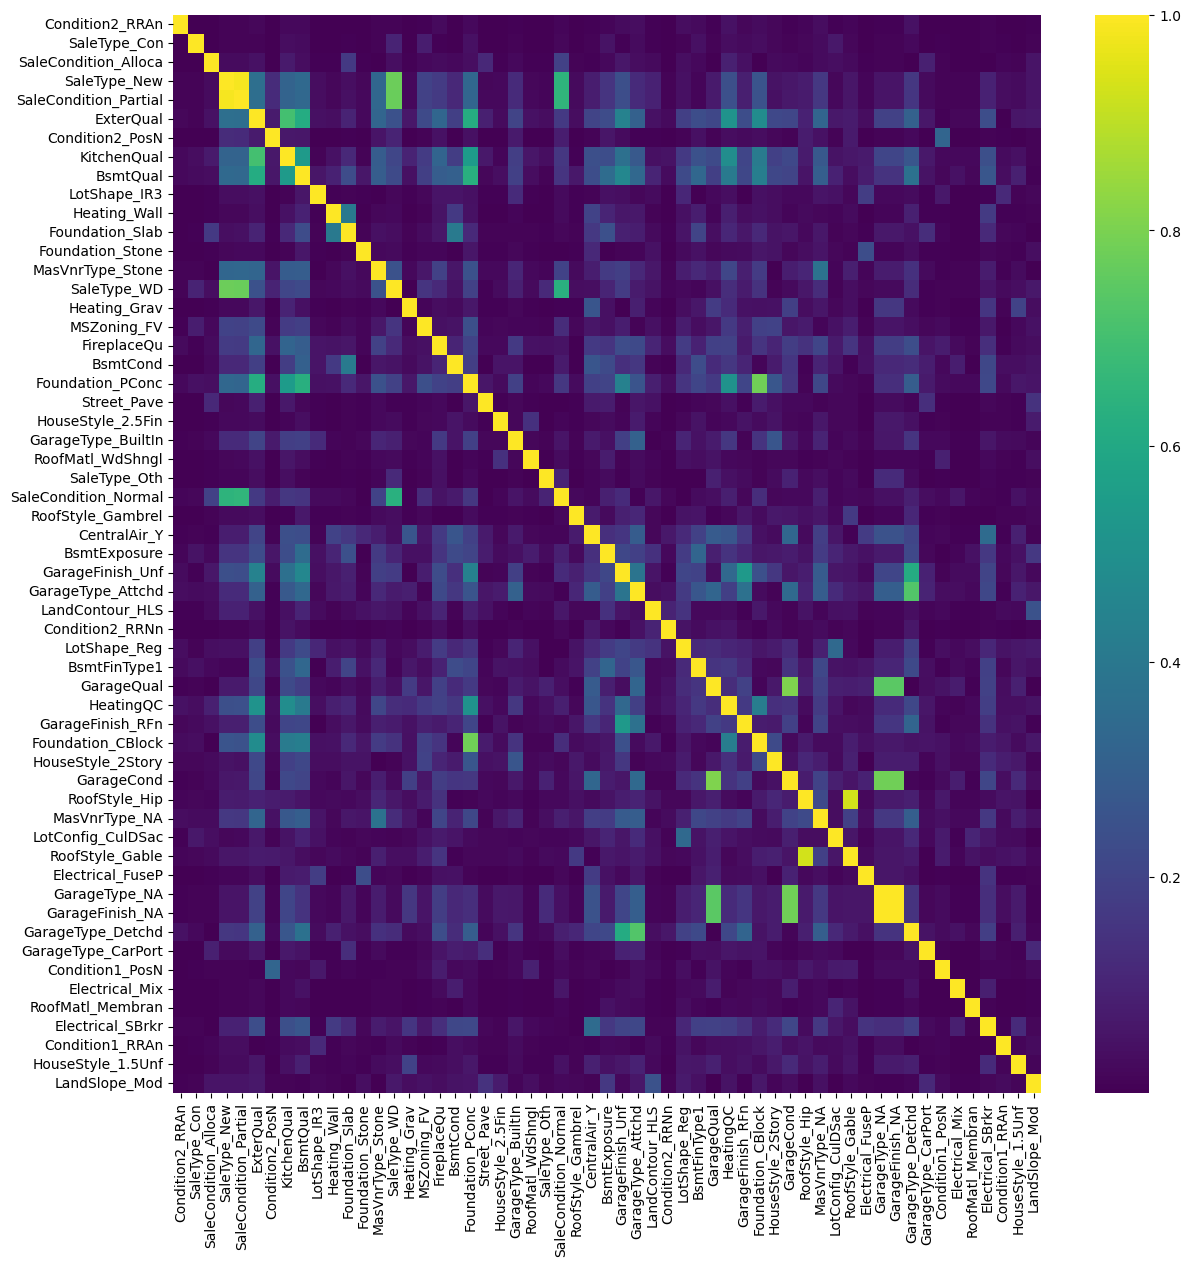

In [ ]:
corr_matrix_kendall = selected_features_df.corr(method ='kendall').abs()
# Create a heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix_kendall, annot=False, cmap='viridis', fmt=".2f")

# Show plot
plt.show()

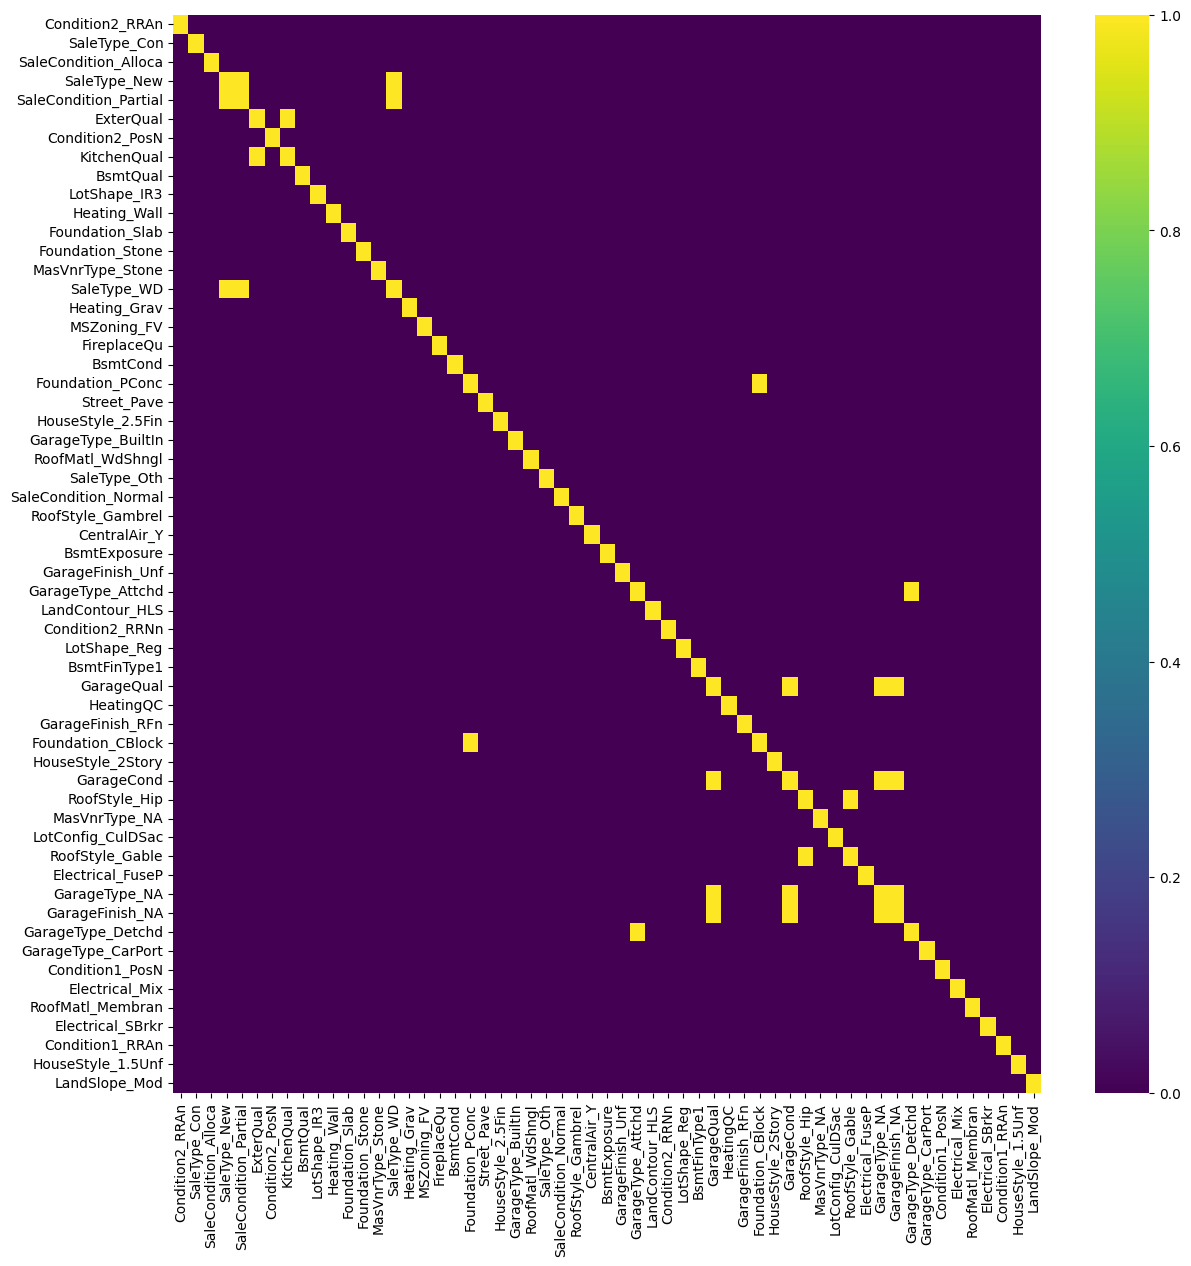

In [ ]:
# Set the correlation threshold
threshold = 0.7  # Adjust this value as needed

# Filter the correlation matrix to select only the features where correlation is less than the threshold
thresholded_features = corr_matrix_kendall > threshold
plt.figure(figsize=(14, 14))

# Plot the thresholded image of the above heatmap
sns.heatmap(thresholded_features, annot=False, cmap='viridis', fmt=".2f")
plt.show()



In [ ]:
# Initialize the array to store the column names that have to be filtered
filtered_features = []

for f1 in list(thresholded_features.columns):
  for f2 in list(thresholded_features.columns):
    if f1!=f2 and (thresholded_features.loc[f1,f2]):
      if f1 not in filtered_features and f2 not in filtered_features:
        filtered_features.append(f2)

print("Features to be filtered from kendells coefficient:\n", set(filtered_features), end = '')

Features to be filtered from kendells coefficient:
 {'Foundation_CBlock', 'GarageCond', 'KitchenQual', 'GarageType_NA', 'SaleType_WD', 'GarageFinish_NA', 'GarageType_Detchd', 'RoofStyle_Gable', 'SaleCondition_Partial'}

In [ ]:
# Select the categorical features after filtering
selected_categorical_features_df = selected_features_df.drop(list(filtered_features), axis = 1)
selected_categorical_features_df_test = selected_features_df_test.drop(list(filtered_features), axis = 1)

# Peek at the selected head
selected_categorical_features_df.head()



,Condition2_RRAn,SaleType_Con,SaleCondition_Alloca,SaleType_New,ExterQual,Condition2_PosN,BsmtQual,LotShape_IR3,Heating_Wall,Foundation_Slab,...,LotConfig_CulDSac,Electrical_FuseP,GarageType_CarPort,Condition1_PosN,Electrical_Mix,RoofMatl_Membran,Electrical_SBrkr,Condition1_RRAn,HouseStyle_1.5Unf,LandSlope_Mod
0,0,0,0,0,4,0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,3,0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,4,0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,3,0,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,4,0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
selected_categorical_features_df_test.head()

,Condition2_RRAn,SaleType_Con,SaleCondition_Alloca,SaleType_New,ExterQual,Condition2_PosN,BsmtQual,LotShape_IR3,Heating_Wall,Foundation_Slab,...,LotConfig_CulDSac,Electrical_FuseP,GarageType_CarPort,Condition1_PosN,Electrical_Mix,RoofMatl_Membran,Electrical_SBrkr,Condition1_RRAn,HouseStyle_1.5Unf,LandSlope_Mod
0,0,0,0,0,3,0,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,3,0,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,3,0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,3,0,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,4,0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0


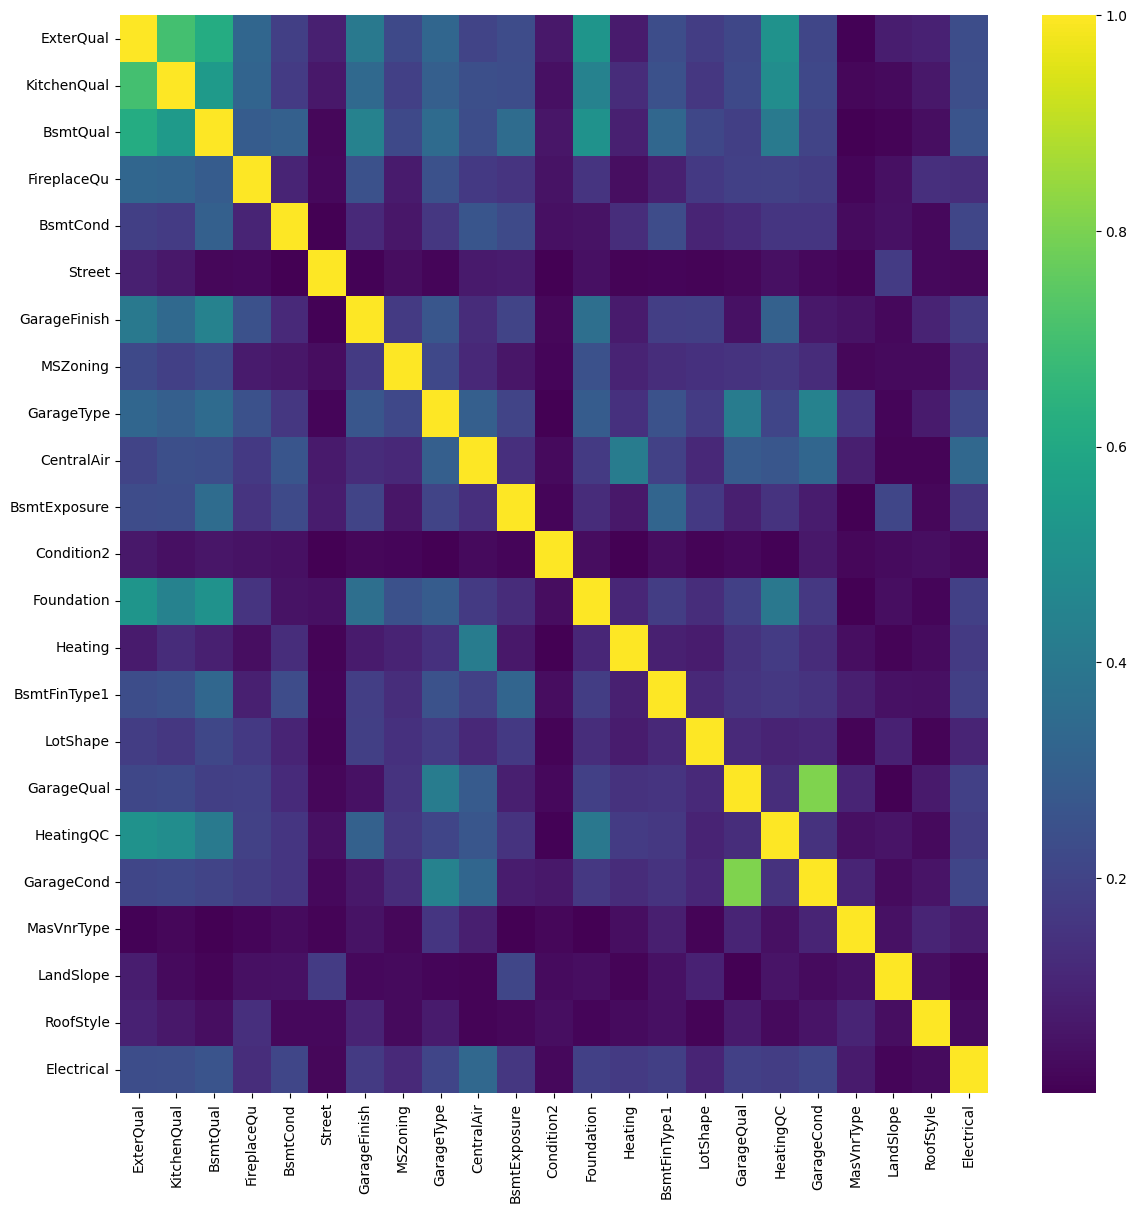

In [ ]:
# Corelation for Label encodings only
corr_matrix_kendall_label = selected_features_df_label.corr(method ='kendall').abs()
# Create a heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix_kendall_label, annot=False, cmap='viridis', fmt=".2f")

# Show plot
plt.show()

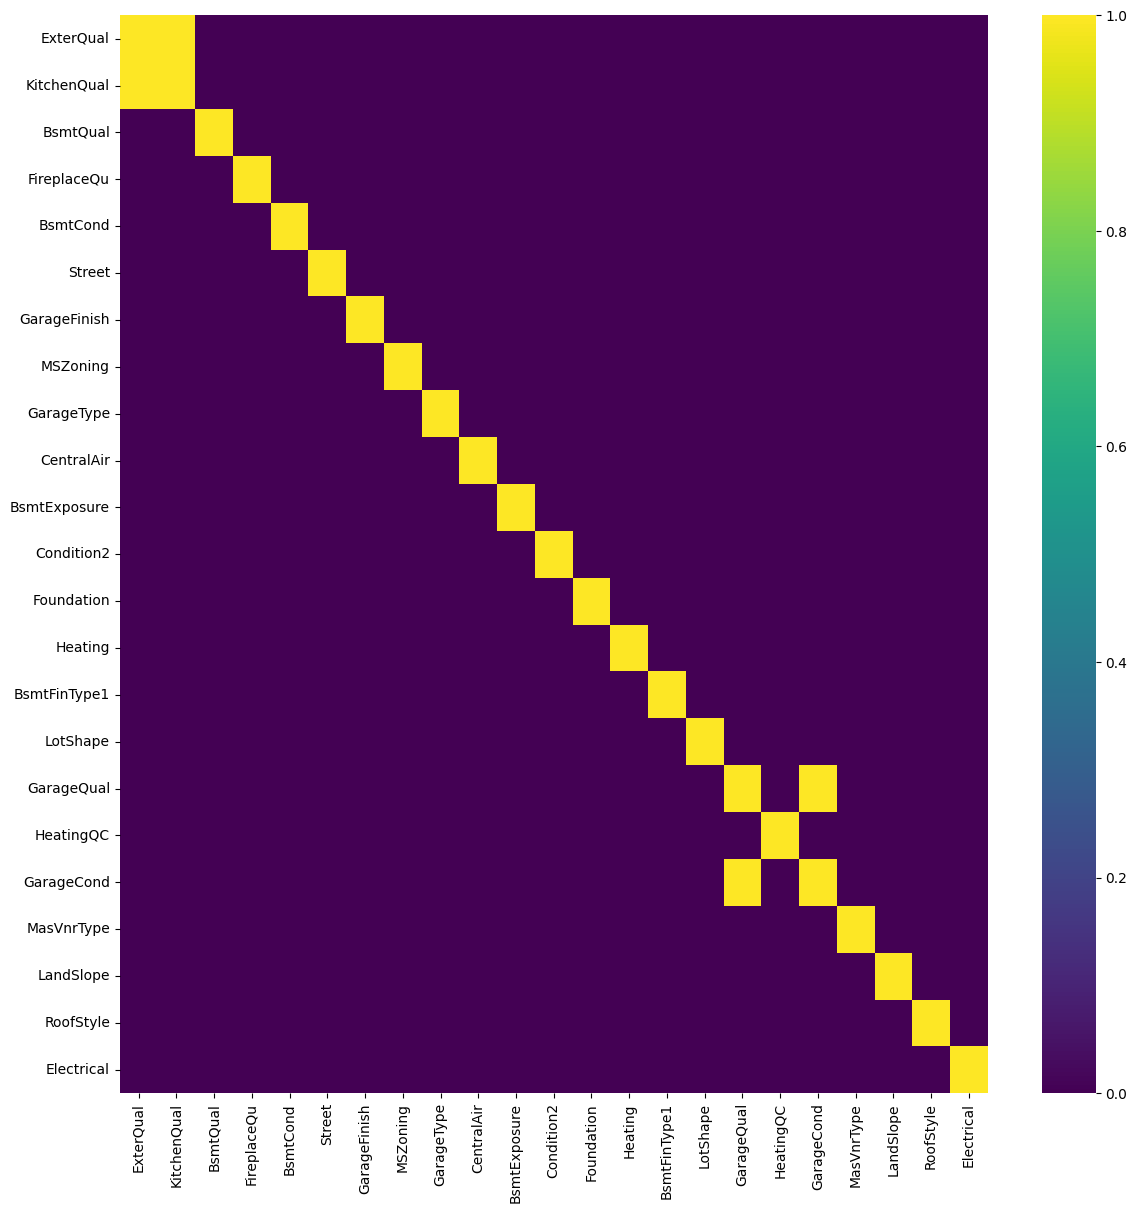

In [ ]:
# Set the correlation threshold
threshold = 0.7  # Adjust this value as needed

# Filter the correlation matrix to select only the features where correlation is less than the threshold
thresholded_features = corr_matrix_kendall_label > threshold
plt.figure(figsize=(14, 14))

# Plot the thresholded image of the above heatmap
sns.heatmap(thresholded_features, annot=False, cmap='viridis', fmt=".2f")
plt.show()


In [ ]:
# Initialize the array to store the column names that have to be filtered
filtered_features_label = []

for f1 in list(thresholded_features.columns):
  for f2 in list(thresholded_features.columns):
    if f1!=f2 and (thresholded_features.loc[f1,f2]):
      if f1 not in filtered_features_label and f2 not in filtered_features_label:
        filtered_features_label.append(f2)

print("Features to be filtered from kendells coefficient:\n", set(filtered_features_label), end = '')

Features to be filtered from kendells coefficient:
 {'KitchenQual', 'GarageCond'}

In [ ]:
# Select the categorical features after filtering
selected_categorical_features_df_label = selected_features_df_label.drop(list(filtered_features_label), axis = 1)
selected_categorical_features_df_label_test = selected_features_df_label_test.drop(list(filtered_features_label), axis = 1)

# Peek at the selected head
selected_categorical_features_df_label.head()

,ExterQual,BsmtQual,FireplaceQu,BsmtCond,Street,GarageFinish,MSZoning,GarageType,CentralAir,BsmtExposure,...,Foundation,Heating,BsmtFinType1,LotShape,GarageQual,HeatingQC,MasVnrType,LandSlope,RoofStyle,Electrical
0,4,4,0,3,1,2,3,1,1,1,...,2,1,6,3,3,5,1,0,1,4
1,3,4,3,3,1,2,3,1,1,4,...,1,1,5,3,3,5,2,0,1,4
2,4,4,3,3,1,2,3,1,1,2,...,2,1,6,0,3,5,1,0,1,4
3,3,3,4,4,1,3,3,5,1,1,...,0,1,5,0,3,4,2,0,1,4
4,4,4,3,3,1,2,3,1,1,3,...,2,1,6,0,3,5,1,0,1,4


In [ ]:
selected_categorical_features_df_label_test.head()

,ExterQual,BsmtQual,FireplaceQu,BsmtCond,Street,GarageFinish,MSZoning,GarageType,CentralAir,BsmtExposure,...,Foundation,Heating,BsmtFinType1,LotShape,GarageQual,HeatingQC,MasVnrType,LandSlope,RoofStyle,Electrical
0,3,3,0,3,1,3,2,1,1,1,...,1,1,3,3,3,3,2,0,1,4
1,3,3,0,3,1,3,3,1,1,1,...,1,1,5,0,3,3,1,0,3,4
2,3,4,3,3,1,0,3,1,1,1,...,2,1,6,0,3,4,2,0,1,4
3,3,3,4,3,1,0,3,1,1,1,...,2,1,6,0,3,5,1,0,1,4
4,4,4,0,3,1,2,3,1,1,1,...,2,1,5,0,3,5,2,0,1,4


5. Performing Target Encoding to Remaining Features

In [ ]:
train_df_categorical[target_encoding_feature_names].nunique()

Neighborhood    25
Exterior1st     15
Exterior2nd     16
dtype: int64

In [ ]:
# Fitting the target encoder
target_encoder = TargetEncoder().fit(train_df_categorical[target_encoding_feature_names], train_df['SalePrice'])

# Encoding the features
selected_categorical_features_df[target_encoding_feature_names] = target_encoder.transform(train_df_categorical[target_encoding_feature_names])
selected_categorical_features_df_test[target_encoding_feature_names] = target_encoder.transform(test_df_categorical[target_encoding_feature_names])


# Fitting the Standard scalar
scaler_target_encoded = StandardScaler().fit(selected_categorical_features_df[target_encoding_feature_names])
scaler_target_encoded_test = StandardScaler().fit(selected_categorical_features_df_test[target_encoding_feature_names])

# Final scaled features fot target encoded features
selected_categorical_features_df[target_encoding_feature_names] = scaler_target_encoded.transform(
    selected_categorical_features_df[target_encoding_feature_names])
selected_categorical_features_df_test[target_encoding_feature_names] = scaler_target_encoded_test.transform(
    selected_categorical_features_df_test[target_encoding_feature_names])


selected_categorical_features_df_label[target_encoding_feature_names] = selected_categorical_features_df[target_encoding_feature_names].copy()
selected_categorical_features_df_label_test[target_encoding_feature_names] = selected_categorical_features_df_test[target_encoding_feature_names].copy()

# Peed at those features
selected_categorical_features_df[target_encoding_feature_names].head()

,Neighborhood,Exterior1st,Exterior2nd
0,0.323832,1.094614,1.137985
1,0.317797,-1.106985,-1.090264
2,0.323832,1.094614,1.137985
3,0.536754,-1.092625,-0.597067
4,2.578465,1.094614,1.137985


In [ ]:
# selected_categorical_features_df_test[target_encoding_feature_names] = target_encoder.transform(test_df_categorical[target_encoding_feature_names])
# scaler_target_encoded_test = StandardScaler().fit(selected_categorical_features_df_test[target_encoding_feature_names])
# selected_categorical_features_df_test[target_encoding_feature_names] = scaler_target_encoded_test.transform(
#     selected_categorical_features_df_test[target_encoding_feature_names])
# selected_categorical_features_df_label_test[target_encoding_feature_names] = selected_categorical_features_df_test[target_encoding_feature_names].copy()


In [ ]:
selected_categorical_features_df_label_test

,ExterQual,BsmtQual,FireplaceQu,BsmtCond,Street,GarageFinish,MSZoning,GarageType,CentralAir,BsmtExposure,...,LotShape,GarageQual,HeatingQC,MasVnrType,LandSlope,RoofStyle,Electrical,Neighborhood,Exterior1st,Exterior2nd
0,3,3,0,3,1,3,2,1,1,1,...,3,3,3,2,0,1,4,-0.618938,1.099639,1.120232
1,3,3,0,3,1,3,3,1,1,1,...,0,3,3,1,0,3,4,-0.618938,-1.070490,-1.129093
2,3,4,3,3,1,0,3,1,1,1,...,0,3,4,2,0,1,4,0.249509,1.099639,1.120232
3,3,3,4,3,1,0,3,1,1,1,...,0,3,5,1,0,1,4,0.249509,1.099639,1.120232
4,4,4,0,3,1,2,3,1,1,1,...,0,3,5,2,0,1,4,1.520638,-0.620923,-0.472632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3,3,0,3,1,1,4,6,1,1,...,3,0,4,2,0,1,4,-0.618352,1.681479,1.623487
1455,3,3,0,3,1,3,4,4,1,1,...,3,3,3,2,0,1,4,-0.618352,1.681479,1.623487
1456,3,3,3,3,1,3,3,5,1,1,...,3,3,5,2,0,1,4,-0.402474,1.099639,1.120232
1457,3,4,0,3,1,1,3,6,1,3,...,3,0,3,2,0,1,4,-0.402474,-0.620923,-0.593651


In [ ]:
selected_categorical_features_df_test

,Condition2_RRAn,SaleType_Con,SaleCondition_Alloca,SaleType_New,ExterQual,Condition2_PosN,BsmtQual,LotShape_IR3,Heating_Wall,Foundation_Slab,...,Condition1_PosN,Electrical_Mix,RoofMatl_Membran,Electrical_SBrkr,Condition1_RRAn,HouseStyle_1.5Unf,LandSlope_Mod,Neighborhood,Exterior1st,Exterior2nd
0,0,0,0,0,3,0,3,0,0,0,...,0,0,0,1,0,0,0,-0.618938,1.099639,1.120232
1,0,0,0,0,3,0,3,0,0,0,...,0,0,0,1,0,0,0,-0.618938,-1.070490,-1.129093
2,0,0,0,0,3,0,4,0,0,0,...,0,0,0,1,0,0,0,0.249509,1.099639,1.120232
3,0,0,0,0,3,0,3,0,0,0,...,0,0,0,1,0,0,0,0.249509,1.099639,1.120232
4,0,0,0,0,4,0,4,0,0,0,...,0,0,0,1,0,0,0,1.520638,-0.620923,-0.472632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,3,0,3,0,0,0,...,0,0,0,1,0,0,0,-0.618352,1.681479,1.623487
1455,0,0,0,0,3,0,3,0,0,0,...,0,0,0,1,0,0,0,-0.618352,1.681479,1.623487
1456,0,0,0,0,3,0,3,0,0,0,...,0,0,0,1,0,0,0,-0.402474,1.099639,1.120232
1457,0,0,0,0,3,0,4,0,0,0,...,0,0,0,1,0,0,0,-0.402474,-0.620923,-0.593651


In [ ]:
# Look at the encoded features
selected_categorical_features_df

,Condition2_RRAn,SaleType_Con,SaleCondition_Alloca,SaleType_New,ExterQual,Condition2_PosN,BsmtQual,LotShape_IR3,Heating_Wall,Foundation_Slab,...,Condition1_PosN,Electrical_Mix,RoofMatl_Membran,Electrical_SBrkr,Condition1_RRAn,HouseStyle_1.5Unf,LandSlope_Mod,Neighborhood,Exterior1st,Exterior2nd
0,0,0,0,0,4,0,4,0,0,0,...,0,0,0,1,0,0,0,0.323832,1.094614,1.137985
1,0,0,0,0,3,0,4,0,0,0,...,0,0,0,1,0,0,0,0.317797,-1.106985,-1.090264
2,0,0,0,0,4,0,4,0,0,0,...,0,0,0,1,0,0,0,0.323832,1.094614,1.137985
3,0,0,0,0,3,0,3,0,0,0,...,0,0,0,1,0,0,0,0.536754,-1.092625,-0.597067
4,0,0,0,0,4,0,4,0,0,0,...,0,0,0,1,0,0,0,2.578465,1.094614,1.137985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,0,3,0,4,0,0,0,...,0,0,0,1,0,0,0,0.227578,1.094614,1.137985
1456,0,0,0,0,3,0,4,0,0,0,...,0,0,0,1,0,0,0,0.156242,-0.199073,-0.459008
1457,0,0,0,0,5,0,3,0,0,0,...,0,0,0,1,0,0,0,0.536754,1.681041,1.647456
1458,0,0,0,0,3,0,3,0,0,0,...,0,0,0,0,0,0,0,-0.651439,-1.106985,-1.090264


In [ ]:
selected_categorical_features_df_label

,ExterQual,BsmtQual,FireplaceQu,BsmtCond,Street,GarageFinish,MSZoning,GarageType,CentralAir,BsmtExposure,...,LotShape,GarageQual,HeatingQC,MasVnrType,LandSlope,RoofStyle,Electrical,Neighborhood,Exterior1st,Exterior2nd
0,4,4,0,3,1,2,3,1,1,1,...,3,3,5,1,0,1,4,0.323832,1.094614,1.137985
1,3,4,3,3,1,2,3,1,1,4,...,3,3,5,2,0,1,4,0.317797,-1.106985,-1.090264
2,4,4,3,3,1,2,3,1,1,2,...,0,3,5,1,0,1,4,0.323832,1.094614,1.137985
3,3,3,4,4,1,3,3,5,1,1,...,0,3,4,2,0,1,4,0.536754,-1.092625,-0.597067
4,4,4,3,3,1,2,3,1,1,3,...,0,3,5,1,0,1,4,2.578465,1.094614,1.137985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,4,3,3,1,2,3,1,1,1,...,3,3,5,2,0,1,4,0.227578,1.094614,1.137985
1456,3,4,3,3,1,3,3,1,1,1,...,3,3,3,3,0,1,4,0.156242,-0.199073,-0.459008
1457,5,3,4,4,1,2,3,1,1,1,...,3,3,5,2,0,1,4,0.536754,1.681041,1.647456
1458,3,3,0,3,1,3,3,1,1,2,...,3,3,4,2,0,3,0,-0.651439,-1.106985,-1.090264


## Analysis of Encoded features


In [ ]:
train_df_non_categorical.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [ ]:
# Number of Nan in each column of non categorical features
# MSSubClass, YearBuilt, YearRemodAdd, OverallQual, OverallCond, GarageYrBlt

train_df_non_categorical.isna().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [ ]:
test_df_non_categorical.isna().sum()

Id                 0
MSSubClass         0
LotFrontage      227
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        15
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       78
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

1. Handling Missing Values

In [ ]:
train_df_non_categorical['GarageYrBlt'].fillna(0, inplace = True)
train_df_non_categorical['GarageYrBlt'] = train_df_non_categorical['GarageYrBlt'].astype('int64')

test_df_non_categorical['GarageYrBlt'].fillna(0, inplace = True)
test_df_non_categorical['GarageYrBlt'] = test_df_non_categorical['GarageYrBlt'].astype('int64')

In [ ]:
# Look at the MasVnrArea data
train_df_non_categorical['MasVnrArea'].value_counts().sort_index()

MasVnrArea
0.0       861
1.0         2
11.0        1
14.0        1
16.0        7
         ... 
1115.0      1
1129.0      1
1170.0      1
1378.0      1
1600.0      1
Name: count, Length: 327, dtype: int64

In [ ]:
test_df_non_categorical['MasVnrArea'].value_counts().sort_index()

MasVnrArea
0.0       877
1.0         1
3.0         1
14.0        3
16.0        4
         ... 
1095.0      1
1110.0      1
1159.0      1
1224.0      2
1290.0      1
Name: count, Length: 303, dtype: int64

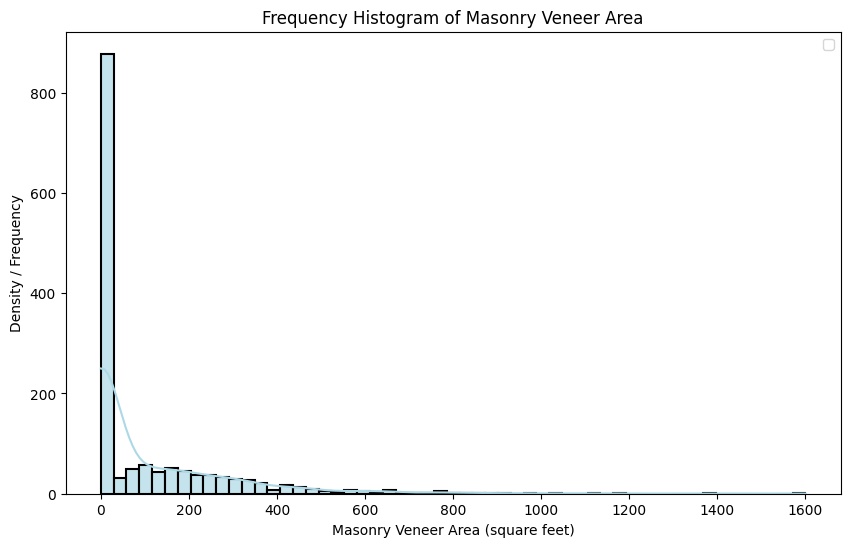

In [ ]:

# Creating the KDE plot with histogram background
plt.figure(figsize=(10, 6))
sns.histplot(train_df_non_categorical['MasVnrArea'], kde=True, color="lightblue", edgecolor="black", linewidth=1.5, alpha=0.7)

# Plot customization
plt.title('Frequency Histogram of Masonry Veneer Area')
plt.xlabel('Masonry Veneer Area (square feet)')
plt.ylabel('Density / Frequency')
plt.legend()
plt.show()

In [ ]:
train_df_non_categorical['MasVnrArea'].fillna(train_df_non_categorical['MasVnrArea'].mode()[0], inplace = True)
test_df_non_categorical['MasVnrArea'].fillna(test_df_non_categorical['MasVnrArea'].mode()[0], inplace = True)

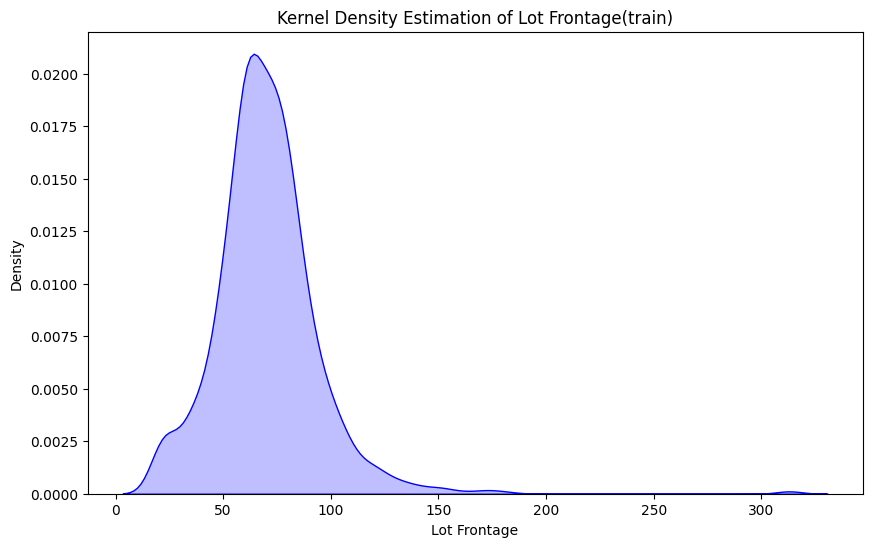

In [ ]:
# Creating the KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(train_df_non_categorical['LotFrontage'], fill = True, color="b")
plt.title('Kernel Density Estimation of Lot Frontage(train)')
plt.xlabel('Lot Frontage')
plt.ylabel('Density')
plt.show()

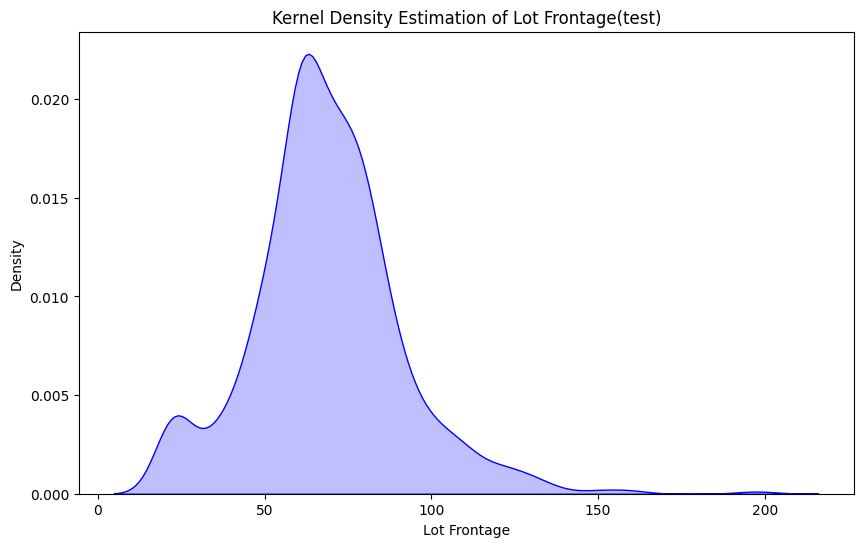

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(test_df_non_categorical['LotFrontage'], fill = True, color="b")
plt.title('Kernel Density Estimation of Lot Frontage(test)')
plt.xlabel('Lot Frontage')
plt.ylabel('Density')
plt.show()

In [ ]:
# I have decided to replace the missing values of LotFrontage by sampling from the KDE this property
# Rather than replacing by mean using KDE to diversify the feature
# Drop missing values for fitting KDE
lot_frontage_non_missing = train_df_non_categorical['LotFrontage'].dropna()


# Fit KDE to non-missing values
kde = gaussian_kde(lot_frontage_non_missing)

# Sample from KDE to replace missing values(train)
missing_indices = train_df_non_categorical['LotFrontage'].isna()
missing_count = missing_indices.sum()
sampled_missing = kde.resample(size=missing_count)[0]

# Replace missing values with sampled values(train)
train_df_non_categorical.loc[missing_indices, 'LotFrontage'] = sampled_missing


# Test
lot_frontage_non_missing_test = test_df_non_categorical['LotFrontage'].dropna()
kde_test = gaussian_kde(lot_frontage_non_missing_test)

# Sample from KDE to replace missing values(test)
missing_indices = test_df_non_categorical['LotFrontage'].isna()
missing_count = missing_indices.sum()
sampled_missing = kde_test.resample(size=missing_count)[0]

# Replace missing values with sampled values
test_df_non_categorical.loc[missing_indices, 'LotFrontage'] = sampled_missing

In [ ]:
# Now all the missing values have been handled
train_df_non_categorical.isna().sum()

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64

In [ ]:
test_df_non_categorical.isna().sum()

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     2
BsmtHalfBath     2
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       1
GarageArea       1
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [ ]:
for col in ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 'GarageCars','GarageArea']:
  test_df_non_categorical[col].fillna(test_df_non_categorical[col].mode()[0], inplace = True)

In [ ]:
# test_df_non_categorical['TotalBsmtSF'].value_counts()

In [ ]:
test_df_non_categorical.isna().sum()

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

1. Handling Date, Time and already encoded Categorical variables

In [ ]:
important_columns = []
for col in ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold' ,'OverallQual', 'OverallCond', 'GarageYrBlt']:

  scores = f_classif(train_df_non_categorical[col].values.reshape(-1,1), train_df['SalePrice'])
  print(f"F-statistic and p-value for {col} are:", scores)
  if scores[1][0] < 0.05:
    important_columns.append(col)






F-statistic and p-value for MSSubClass are: (array([0.87260303]), array([0.96599801]))
F-statistic and p-value for YearBuilt are: (array([2.31019773]), array([1.2908904e-29]))
F-statistic and p-value for YearRemodAdd are: (array([1.82760284]), array([2.28852795e-16]))
F-statistic and p-value for YrSold are: (array([1.06953295]), array([0.18226934]))
F-statistic and p-value for MoSold are: (array([0.94758753]), array([0.76446191]))
F-statistic and p-value for OverallQual are: (array([5.72918291]), array([1.34439905e-114]))
F-statistic and p-value for OverallCond are: (array([1.1035498]), array([0.09200359]))
F-statistic and p-value for GarageYrBlt are: (array([1.28519179]), array([0.0003576]))


In [ ]:
important_columns

['YearBuilt', 'YearRemodAdd', 'OverallQual', 'GarageYrBlt']

Lets visualize the results provided by ANOVA

The average price vaires depending upon the last year it was modified.

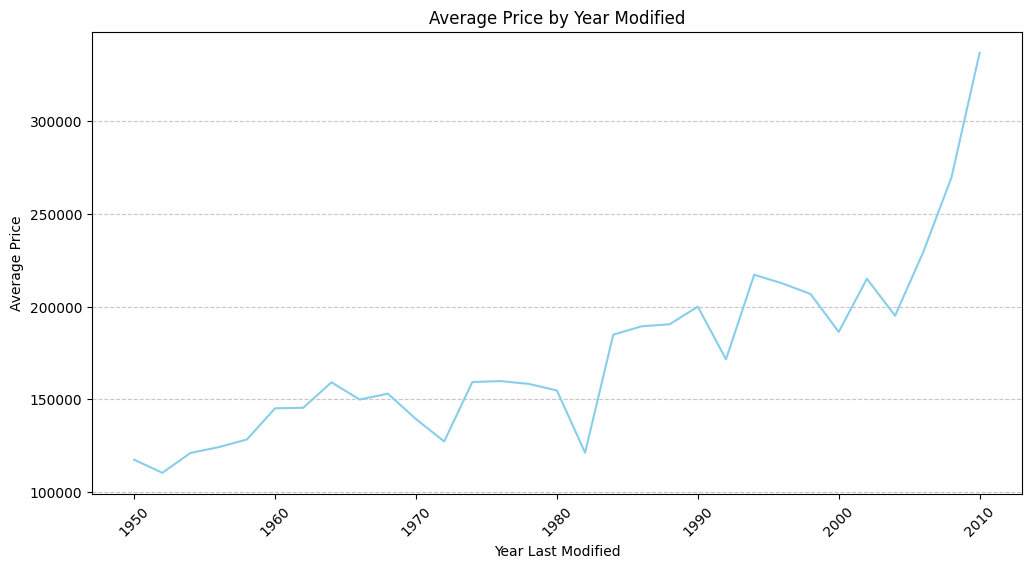

In [ ]:
# Find the average price by last year modified
average_price_by_year_modified = train_df_non_categorical.groupby('YearRemodAdd')['SalePrice'].mean()

# Filter every two data points
average_price_by_year_modified_filtered = average_price_by_year_modified.iloc[::2]

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_price_by_year_modified_filtered,color='skyblue')
plt.title('Average Price by Year Modified')
plt.xlabel('Year Last Modified')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The average price is almost constant and doesn't depend upon the month on which it is sold

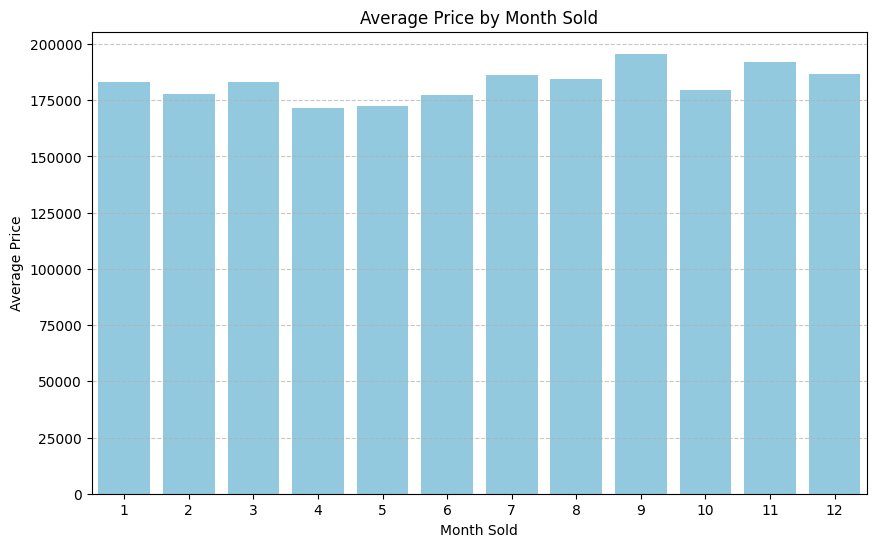

In [ ]:
# Find the average price by month sold
average_price_by_month_sold = train_df_non_categorical.groupby('MoSold')['SalePrice'].mean()


plt.figure(figsize=(10, 6))
sns.barplot(data=average_price_by_month_sold,color='skyblue')
plt.title('Average Price by Month Sold')
plt.xlabel('Month Sold')
plt.ylabel('Average Price')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

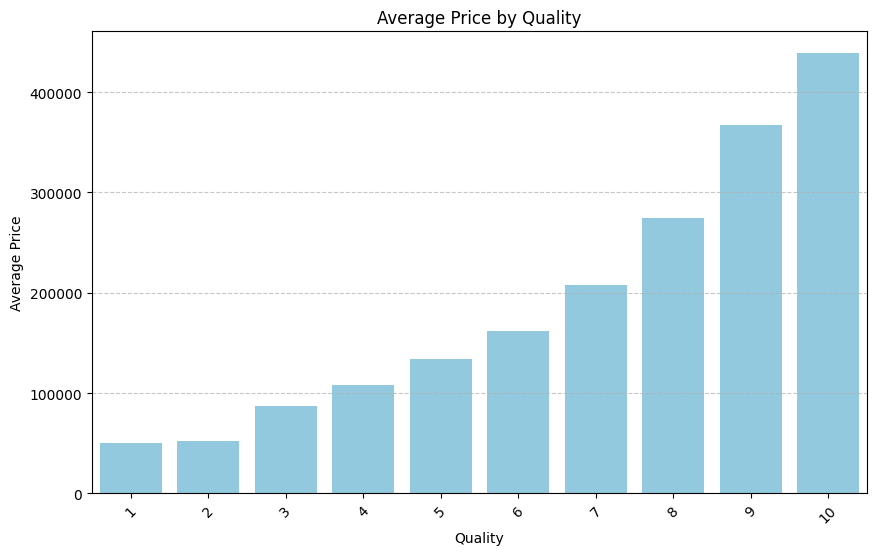

In [ ]:
average_price_by_quality = train_df_non_categorical.groupby('OverallQual')['SalePrice'].mean()


# Plotting the average price by quality
# We can see that the price varies drastically as the quality becomes better
# Hence we see that it is an important feature as was revealed by ANOVA test
plt.figure(figsize=(10, 6))
sns.barplot(data=average_price_by_quality,color='skyblue')
plt.title('Average Price by Quality')
plt.xlabel('Quality')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

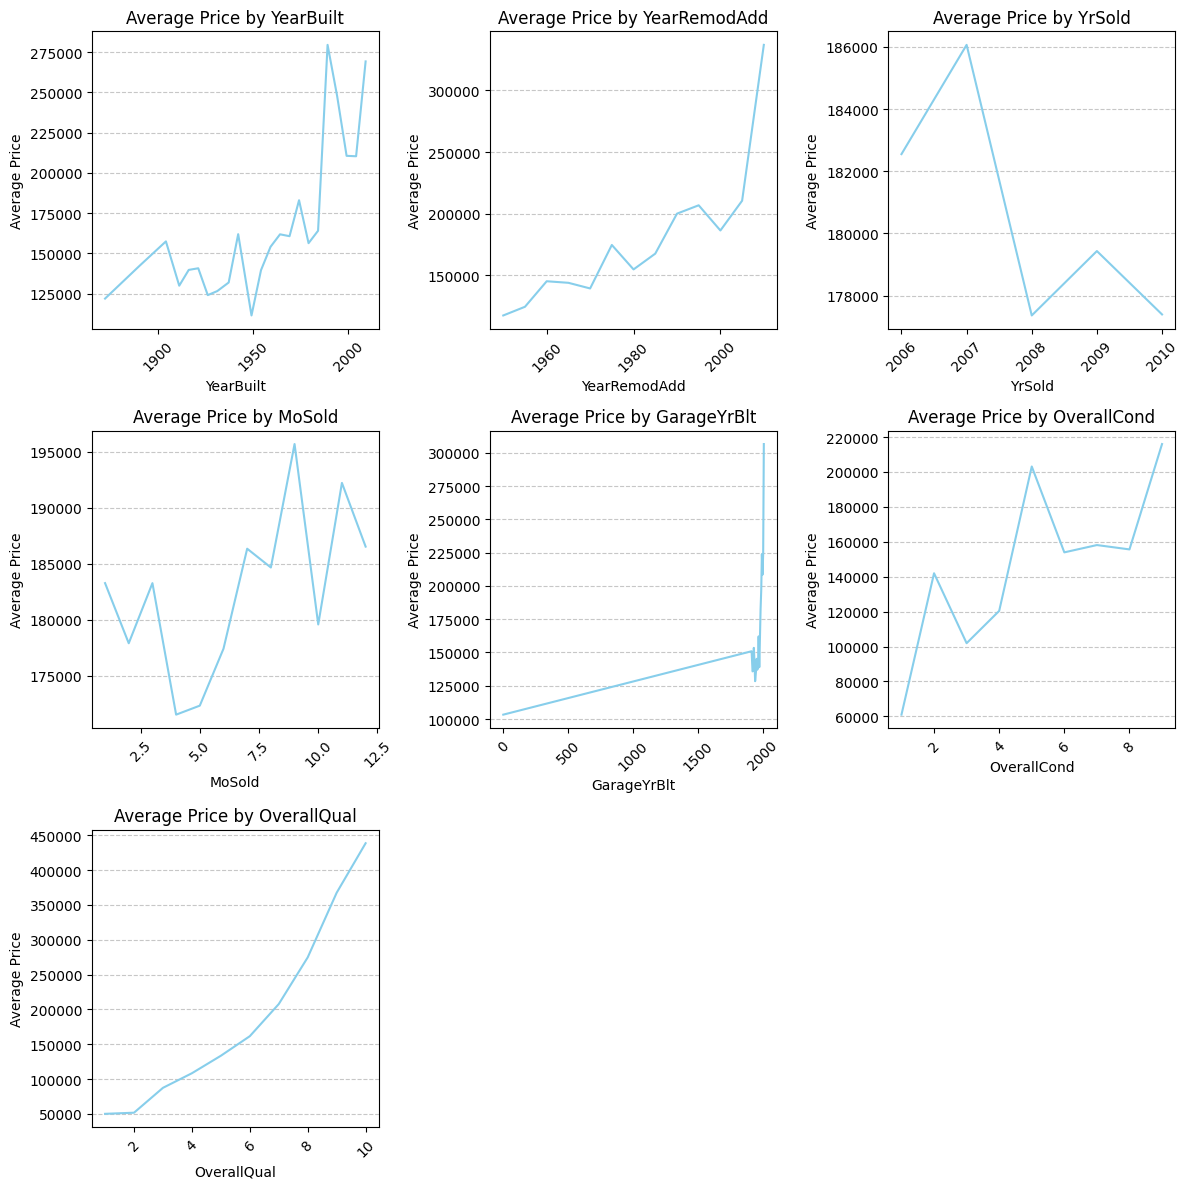

In [ ]:
# Columns for which we want to plot average price
columns_to_plot = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold', 'GarageYrBlt', 'OverallCond', 'OverallQual']

# Plotting
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()


# Plotting all the categorical columns
for i, column in enumerate(columns_to_plot):
    average_price_by_column = train_df_non_categorical.groupby(column)['SalePrice'].mean().reset_index()
    if column in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
        average_price_by_column_filtered = average_price_by_column.iloc[::5]
        sns.lineplot(data=average_price_by_column_filtered, x=column, y='SalePrice', color='skyblue', ax=axes[i])
    else:
        sns.lineplot(data=average_price_by_column, x=column, y='SalePrice', color='skyblue', ax=axes[i])
    axes[i].set_title(f'Average Price by {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Average Price')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Remove the remaining axes
for j in range(len(columns_to_plot), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_df_non_categorical['GarageYrBlt'].describe()

count    1459.000000
mean     1871.989719
std       445.786118
min         0.000000
25%      1956.000000
50%      1977.000000
75%      2001.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

In [ ]:
# Year sold is 2007 and year built is also 2007 hence, use 2007 inplace of 2207
test_df_non_categorical.loc[test_df_non_categorical[
    test_df_non_categorical['GarageYrBlt'].astype(int) == 2207].index,'GarageYrBlt' ] = 2007

In [ ]:
test_df_non_categorical['GarageYrBlt'].describe()

count    1459.000000
mean     1871.852639
std       445.713775
min         0.000000
25%      1956.000000
50%      1977.000000
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [ ]:
# Columns to encode
columns_to_encode = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

# Define bin edges (decades)
bin_edges = [ -1, 1950, 1960, 1970, 1980, 1990, 2000, 2011]

# Encode the years using binning
for column in columns_to_encode:
    train_df_non_categorical[column] = pd.cut(train_df_non_categorical[column], bins=bin_edges, labels=False).astype('int64')
    test_df_non_categorical[column] = pd.cut(test_df_non_categorical[column], bins=bin_edges, labels=False).astype('int64')

train_df_non_categorical[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].nunique()

YearBuilt       7
YearRemodAdd    7
GarageYrBlt     7
dtype: int64

In [ ]:
test_df_non_categorical[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].nunique()

YearBuilt       7
YearRemodAdd    7
GarageYrBlt     7
dtype: int64

In [ ]:
# Columns to drop
columns_to_drop = ['YrSold', 'MoSold', 'OverallCond']
train_df_non_categorical.drop(['YrSold', 'MoSold', 'OverallCond'], inplace = True, axis = 1)
test_df_non_categorical.drop(['YrSold', 'MoSold', 'OverallCond'], inplace = True, axis = 1)

In [ ]:
# y = train_df_non_categorical['SalePrice']
selected_categorical_features_df = pd.concat((selected_categorical_features_df,train_df_non_categorical[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'OverallQual']]), axis = 1 )
selected_categorical_features_df_label = pd.concat((selected_categorical_features_df_label,train_df_non_categorical[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'OverallQual']]), axis = 1 )

selected_categorical_features_df_test = pd.concat((selected_categorical_features_df_test,test_df_non_categorical[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'OverallQual']]), axis = 1 )
selected_categorical_features_df_label_test = pd.concat((selected_categorical_features_df_label_test,test_df_non_categorical[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'OverallQual']]), axis = 1 )

In [ ]:
selected_categorical_features_df_label.head()

,ExterQual,BsmtQual,FireplaceQu,BsmtCond,Street,GarageFinish,MSZoning,GarageType,CentralAir,BsmtExposure,...,LandSlope,RoofStyle,Electrical,Neighborhood,Exterior1st,Exterior2nd,YearBuilt,YearRemodAdd,GarageYrBlt,OverallQual
0,4,4,0,3,1,2,3,1,1,1,...,0,1,4,0.323832,1.094614,1.137985,6,6,6,7
1,3,4,3,3,1,2,3,1,1,4,...,0,1,4,0.317797,-1.106985,-1.090264,3,3,3,6
2,4,4,3,3,1,2,3,1,1,2,...,0,1,4,0.323832,1.094614,1.137985,6,6,6,7
3,3,3,4,4,1,3,3,5,1,1,...,0,1,4,0.536754,-1.092625,-0.597067,0,2,5,7
4,4,4,3,3,1,2,3,1,1,3,...,0,1,4,2.578465,1.094614,1.137985,5,5,5,8


In [ ]:
selected_categorical_features_df_label_test.head()

,ExterQual,BsmtQual,FireplaceQu,BsmtCond,Street,GarageFinish,MSZoning,GarageType,CentralAir,BsmtExposure,...,LandSlope,RoofStyle,Electrical,Neighborhood,Exterior1st,Exterior2nd,YearBuilt,YearRemodAdd,GarageYrBlt,OverallQual
0,3,3,0,3,1,3,2,1,1,1,...,0,1,4,-0.618938,1.099639,1.120232,2,2,2,5
1,3,3,0,3,1,3,3,1,1,1,...,0,3,4,-0.618938,-1.070490,-1.129093,1,1,1,6
2,3,4,3,3,1,0,3,1,1,1,...,0,1,4,0.249509,1.099639,1.120232,5,5,5,5
3,3,3,4,3,1,0,3,1,1,1,...,0,1,4,0.249509,1.099639,1.120232,5,5,5,6
4,4,4,0,3,1,2,3,1,1,1,...,0,1,4,1.520638,-0.620923,-0.472632,5,5,5,8


In [ ]:
selected_categorical_features_df.head()

,Condition2_RRAn,SaleType_Con,SaleCondition_Alloca,SaleType_New,ExterQual,Condition2_PosN,BsmtQual,LotShape_IR3,Heating_Wall,Foundation_Slab,...,Condition1_RRAn,HouseStyle_1.5Unf,LandSlope_Mod,Neighborhood,Exterior1st,Exterior2nd,YearBuilt,YearRemodAdd,GarageYrBlt,OverallQual
0,0,0,0,0,4,0,4,0,0,0,...,0,0,0,0.323832,1.094614,1.137985,6,6,6,7
1,0,0,0,0,3,0,4,0,0,0,...,0,0,0,0.317797,-1.106985,-1.090264,3,3,3,6
2,0,0,0,0,4,0,4,0,0,0,...,0,0,0,0.323832,1.094614,1.137985,6,6,6,7
3,0,0,0,0,3,0,3,0,0,0,...,0,0,0,0.536754,-1.092625,-0.597067,0,2,5,7
4,0,0,0,0,4,0,4,0,0,0,...,0,0,0,2.578465,1.094614,1.137985,5,5,5,8


In [ ]:
selected_categorical_features_df_test.head()

,Condition2_RRAn,SaleType_Con,SaleCondition_Alloca,SaleType_New,ExterQual,Condition2_PosN,BsmtQual,LotShape_IR3,Heating_Wall,Foundation_Slab,...,Condition1_RRAn,HouseStyle_1.5Unf,LandSlope_Mod,Neighborhood,Exterior1st,Exterior2nd,YearBuilt,YearRemodAdd,GarageYrBlt,OverallQual
0,0,0,0,0,3,0,3,0,0,0,...,0,0,0,-0.618938,1.099639,1.120232,2,2,2,5
1,0,0,0,0,3,0,3,0,0,0,...,0,0,0,-0.618938,-1.070490,-1.129093,1,1,1,6
2,0,0,0,0,3,0,4,0,0,0,...,0,0,0,0.249509,1.099639,1.120232,5,5,5,5
3,0,0,0,0,3,0,3,0,0,0,...,0,0,0,0.249509,1.099639,1.120232,5,5,5,6
4,0,0,0,0,4,0,4,0,0,0,...,0,0,0,1.520638,-0.620923,-0.472632,5,5,5,8


## Analyzing Continuous Features

In [ ]:
continuous_features = list(set(train_df_non_categorical.columns) - set(columns_to_plot) - set(['Id', 'SalePrice']))
train_df_continuous = train_df_non_categorical[continuous_features]
test_df_continuous = test_df_non_categorical[continuous_features]

1. Feature Selection using Pearson Corelation Coefficient

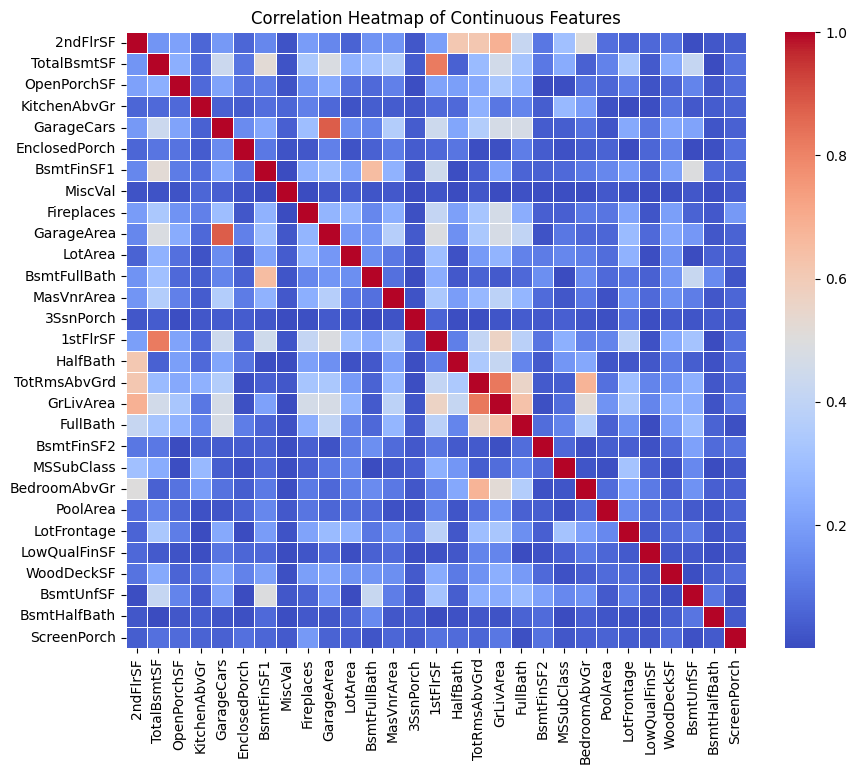

In [ ]:

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_df_continuous.corr().abs(), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Continuous Features')
plt.show()

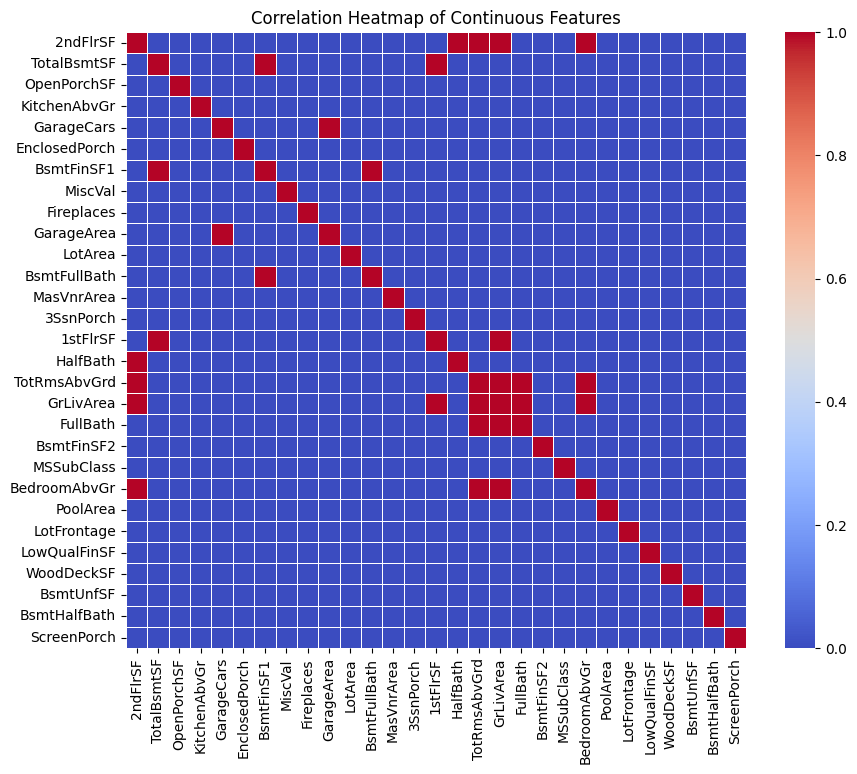

In [ ]:
threshold = 0.5
thresholded_features = train_df_continuous.corr().abs() > threshold

# Plot the threshold heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(thresholded_features, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Continuous Features')
plt.show()


In [ ]:
# Initialize the array to store the column names that have to be filtered
filtered_features = []

for f1 in list(thresholded_features.columns):
  for f2 in list(thresholded_features.columns):
    if f1!=f2 and (thresholded_features.loc[f1,f2]):
      if f1 not in filtered_features and f2 not in filtered_features:
        filtered_features.append(f2)

print("Features to be filtered from Pearson coefficient:\n", set(filtered_features), end = '')

Features to be filtered from Pearson coefficient:
 {'1stFlrSF', 'TotRmsAbvGrd', 'BsmtFinSF1', 'GrLivArea', 'BedroomAbvGr', 'GarageArea', 'HalfBath'}

In [ ]:
train_df_continuous_selected = train_df_continuous.drop(filtered_features, axis = 1)
test_df_continuous_selected = test_df_continuous.drop(filtered_features, axis = 1)

In [ ]:
train_df_continuous_selected

,2ndFlrSF,TotalBsmtSF,OpenPorchSF,KitchenAbvGr,GarageCars,EnclosedPorch,MiscVal,Fireplaces,LotArea,BsmtFullBath,...,FullBath,BsmtFinSF2,MSSubClass,PoolArea,LotFrontage,LowQualFinSF,WoodDeckSF,BsmtUnfSF,BsmtHalfBath,ScreenPorch
0,854,856,61,1,2,0,0,0,8450,1,...,2,0,60,0,65.0,0,0,150,0,0
1,0,1262,0,1,2,0,0,1,9600,0,...,2,0,20,0,80.0,0,298,284,1,0
2,866,920,42,1,2,0,0,1,11250,1,...,2,0,60,0,68.0,0,0,434,0,0
3,756,756,35,1,3,272,0,1,9550,1,...,1,0,70,0,60.0,0,0,540,0,0
4,1053,1145,84,1,3,0,0,1,14260,1,...,2,0,60,0,84.0,0,192,490,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,694,953,40,1,2,0,0,1,7917,0,...,2,0,60,0,62.0,0,0,953,0,0
1456,0,1542,0,1,2,0,0,2,13175,1,...,2,163,20,0,85.0,0,349,589,0,0
1457,1152,1152,60,1,1,0,2500,2,9042,0,...,2,0,70,0,66.0,0,0,877,0,0
1458,0,1078,0,1,1,112,0,0,9717,1,...,1,1029,20,0,68.0,0,366,0,0,0


2. Multicolinearity test

The test reveals that no columns need to be dropped due to multicolinearity

In [ ]:
while(True):
  # Add a constant column to the DataFrame
  df_with_const = add_constant(train_df_continuous_selected)

  # Calculate VIF for each predictor variable
  vif_data = pd.DataFrame()
  vif_data["Variable"] = df_with_const.columns
  vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]
  if vif_data.sort_values(by = 'VIF',ascending = False).reset_index().loc[1,'VIF'] > 5:
    column = vif_data.sort_values(by = 'VIF',ascending = False).reset_index().loc[1,'Variable']
    print("Dropped:", column)
    train_df_continuous_selected.drop([column],axis = 1, inplace = True)
  else:
    break

# Display the DataFrame containing VIF values
print("----------------------------------")
print("Columns to keep after iteratively dropping:\n",vif_data.sort_values(by = 'VIF', ascending = False).reset_index().iloc[1:,:])

----------------------------------
Columns to keep after iteratively dropping:
     index       Variable       VIF
1       2    TotalBsmtSF  3.169971
2      20      BsmtUnfSF  2.431914
3      10   BsmtFullBath  2.139963
4      13       FullBath  1.832484
5       1       2ndFlrSF  1.780712
6       5     GarageCars  1.605028
7      15     MSSubClass  1.462370
8       8     Fireplaces  1.361718
9      17    LotFrontage  1.359506
10     11     MasVnrArea  1.330940
11      9        LotArea  1.196680
12     19     WoodDeckSF  1.185249
13      4   KitchenAbvGr  1.181264
14      3    OpenPorchSF  1.177763
15     14     BsmtFinSF2  1.145509
16     21   BsmtHalfBath  1.121416
17      6  EnclosedPorch  1.091402
18     22    ScreenPorch  1.086739
19     16       PoolArea  1.072076
20     18   LowQualFinSF  1.033507
21     12      3SsnPorch  1.020545
22      7        MiscVal  1.014879


3. Recursive Feature Estimator with Lasso for selection

In [ ]:
from sklearn.linear_model import LinearRegression
def select_features_with_rfe_cv(estimator, X, y, cv=7):
    """
    Select features using RFE with cross-validation (RFECV).

    Parameters:
        estimator: object
            The ML estimator for feature selection.
        X: array-like, shape (n_samples, n_features)
            The input samples.
        y: array-like, shape (n_samples,)
            The target values.
        cv: int or cross-validation generator, optional (default=5)
            Determines cross-validation splitting.

    Returns:
        selected_features: array-like, shape (n_features,)
            Boolean array indicating selected features.
    """

    # Initialize the RFECV selector with the estimator and cross-validation strategy
    selector = RFECV(estimator, cv=cv, scoring='r2')

    # Fit the selector to the data
    selector.fit(X, y)

    return selector.support_

estimator = Lasso()
# Select the number of features as given by the cross validation
selected_features_id = select_features_with_rfe_cv(estimator,train_df_continuous_selected , train_df['SalePrice'])
selected_features_rfecv = train_df_continuous_selected.columns[selected_features_id].tolist()
# Print the features that are selected
print("Selected features:",  selected_features_rfecv)
print("Columns that are left out:",set(train_df_continuous_selected.columns) - set(selected_features_rfecv))

Selected features: ['2ndFlrSF', 'TotalBsmtSF', 'OpenPorchSF', 'KitchenAbvGr', 'GarageCars', 'Fireplaces', 'BsmtFullBath', 'MasVnrArea', '3SsnPorch', 'FullBath', 'MSSubClass', 'PoolArea', 'LowQualFinSF', 'WoodDeckSF', 'BsmtHalfBath', 'ScreenPorch']
Columns that are left out: {'EnclosedPorch', 'MiscVal', 'LotFrontage', 'BsmtUnfSF', 'LotArea', 'BsmtFinSF2'}


In [ ]:
# Drop the column based on above weighting method with lasso
train_df_continuous_selected.drop(list(set(train_df_continuous_selected.columns) - set(selected_features_rfecv)) , axis = 1, inplace = True)
test_df_continuous_selected.drop(list(set(test_df_continuous_selected.columns) - set(selected_features_rfecv)) , axis = 1, inplace = True)

In [ ]:
train_df_continuous_selected

,2ndFlrSF,TotalBsmtSF,OpenPorchSF,KitchenAbvGr,GarageCars,Fireplaces,BsmtFullBath,MasVnrArea,3SsnPorch,FullBath,MSSubClass,PoolArea,LowQualFinSF,WoodDeckSF,BsmtHalfBath,ScreenPorch
0,854,856,61,1,2,0,1,196.0,0,2,60,0,0,0,0,0
1,0,1262,0,1,2,1,0,0.0,0,2,20,0,0,298,1,0
2,866,920,42,1,2,1,1,162.0,0,2,60,0,0,0,0,0
3,756,756,35,1,3,1,1,0.0,0,1,70,0,0,0,0,0
4,1053,1145,84,1,3,1,1,350.0,0,2,60,0,0,192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,694,953,40,1,2,1,0,0.0,0,2,60,0,0,0,0,0
1456,0,1542,0,1,2,2,1,119.0,0,2,20,0,0,349,0,0
1457,1152,1152,60,1,1,2,0,0.0,0,2,70,0,0,0,0,0
1458,0,1078,0,1,1,0,1,0.0,0,1,20,0,0,366,0,0


In [ ]:
test_df_continuous_selected

,2ndFlrSF,TotalBsmtSF,OpenPorchSF,KitchenAbvGr,GarageCars,Fireplaces,BsmtFullBath,MasVnrArea,3SsnPorch,FullBath,MSSubClass,PoolArea,LowQualFinSF,WoodDeckSF,BsmtHalfBath,ScreenPorch
0,0,882.0,0,1,1.0,0,0.0,0.0,0,1,20,0,0,140,0.0,120
1,0,1329.0,36,1,1.0,0,0.0,108.0,0,1,20,0,0,393,0.0,0
2,701,928.0,34,1,2.0,1,0.0,0.0,0,2,60,0,0,212,0.0,0
3,678,926.0,36,1,2.0,1,0.0,20.0,0,2,60,0,0,360,0.0,0
4,0,1280.0,82,1,2.0,0,0.0,0.0,0,2,120,0,0,0,0.0,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,546,546.0,0,1,0.0,0,0.0,0.0,0,1,160,0,0,0,0.0,0
1455,546,546.0,24,1,1.0,0,0.0,0.0,0,1,160,0,0,0,0.0,0
1456,0,1224.0,0,1,2.0,1,1.0,0.0,0,1,20,0,0,474,0.0,0
1457,0,912.0,32,1,0.0,0,0.0,0.0,0,1,85,0,0,80,1.0,0


4. Box Plots

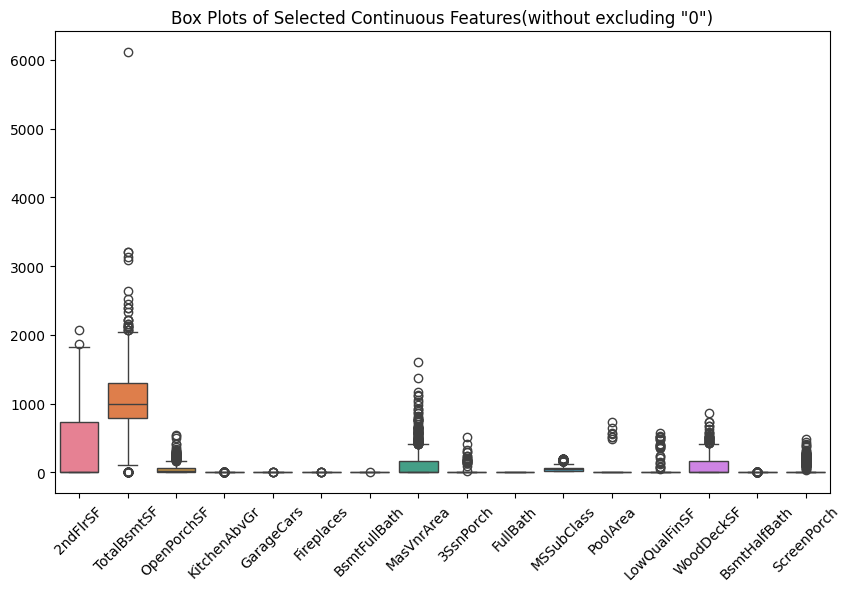

In [ ]:
# Create a box plot for each feature in the DataFrame
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df_continuous_selected)
plt.title('Box Plots of Selected Continuous Features(without excluding "0")')
plt.xticks(rotation=45)
plt.show()

5. PCA and t-SNE

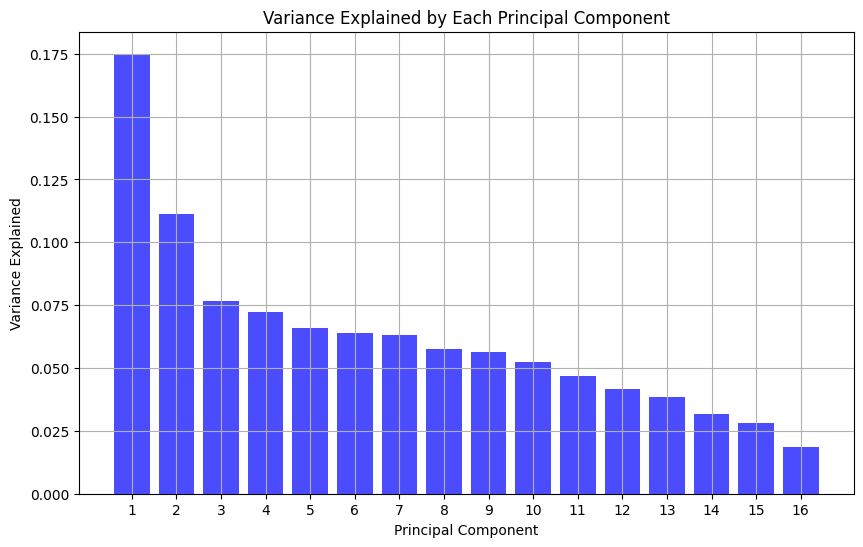

In [ ]:
# 11. Perform dimensionality reduction using PCA and t-SNE. Compare the
# features obtained from both methods
from sklearn.decomposition import PCA

# X = selected_features_raisin.select_dtypes(include=['float64', 'int64'])

# Step 1: Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_df_continuous_selected)

# Step 2: Perform PCA
pca = PCA()
features_pca = pca.fit_transform(scaled_features)

# Step 3: Plot the variance explained by each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='blue', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, pca.n_components_ + 1))
plt.grid(True)
plt.show()

The two most important features after PCA finds to clusters!

<ipython-input-94-736b47186cc2>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_pca[:, 0], features_pca[:, 1], cmap='viridis')


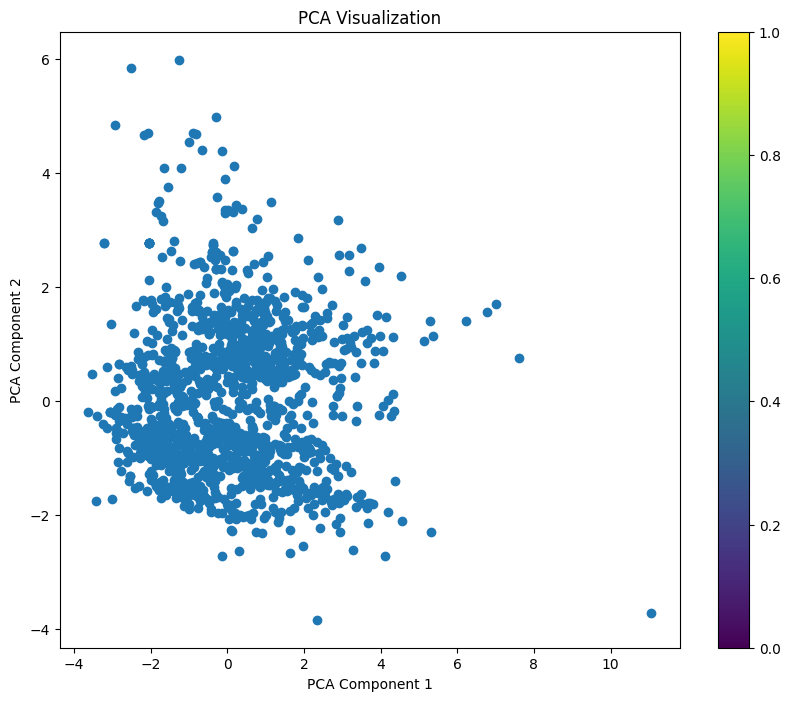

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], cmap='viridis')
plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

In [ ]:
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Perform t-SNE dimensionality reduction
features_tsne = tsne.fit_transform(scaled_features)



<ipython-input-96-0022e8f4fdd1>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_tsne[:, 0], features_tsne[:, 1],cmap = 'viridis')


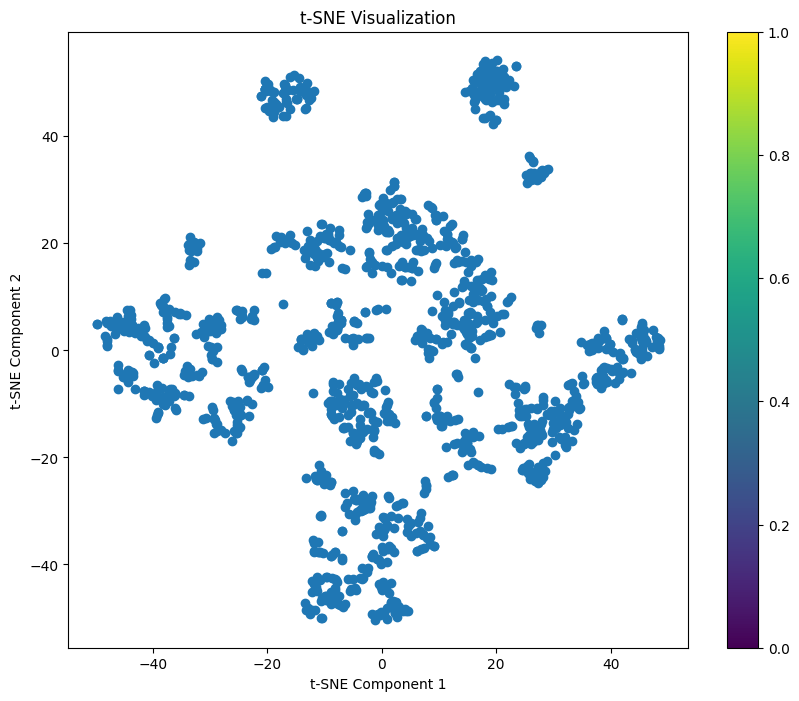

In [ ]:
# Plot the reduced data
# LabelEncoder().fit_transform(train_df_encoded['YearRemodAdd'])
# train_df_non_categorical['OverallQual']
plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1],cmap = 'viridis')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

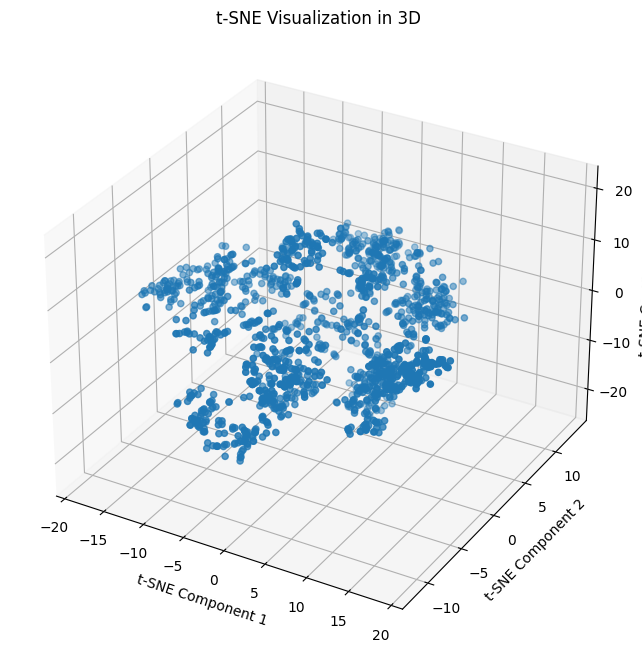

In [ ]:
# Initialize t-SNE
tsne = TSNE(n_components=3, random_state=42)

# Perform t-SNE dimensionality reduction
features_tsne_3 = tsne.fit_transform(scaled_features)

# Plot the reduced data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne_3[:, 0], features_tsne_3[:, 1], features_tsne_3[:, 2])
ax.set_title('t-SNE Visualization in 3D')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()

## Model Building and Prediction

1. Combined Features

In [ ]:
selected_categorical_features_df_label

,ExterQual,BsmtQual,FireplaceQu,BsmtCond,Street,GarageFinish,MSZoning,GarageType,CentralAir,BsmtExposure,...,LandSlope,RoofStyle,Electrical,Neighborhood,Exterior1st,Exterior2nd,YearBuilt,YearRemodAdd,GarageYrBlt,OverallQual
0,4,4,0,3,1,2,3,1,1,1,...,0,1,4,0.323832,1.094614,1.137985,6,6,6,7
1,3,4,3,3,1,2,3,1,1,4,...,0,1,4,0.317797,-1.106985,-1.090264,3,3,3,6
2,4,4,3,3,1,2,3,1,1,2,...,0,1,4,0.323832,1.094614,1.137985,6,6,6,7
3,3,3,4,4,1,3,3,5,1,1,...,0,1,4,0.536754,-1.092625,-0.597067,0,2,5,7
4,4,4,3,3,1,2,3,1,1,3,...,0,1,4,2.578465,1.094614,1.137985,5,5,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,4,3,3,1,2,3,1,1,1,...,0,1,4,0.227578,1.094614,1.137985,5,5,5,6
1456,3,4,3,3,1,3,3,1,1,1,...,0,1,4,0.156242,-0.199073,-0.459008,3,4,3,6
1457,5,3,4,4,1,2,3,1,1,1,...,0,1,4,0.536754,1.681041,1.647456,0,6,0,7
1458,3,3,0,3,1,3,3,1,1,2,...,0,3,0,-0.651439,-1.106985,-1.090264,0,5,0,5


In [ ]:
# 17 dimensions can explain more than 95% of the variance in features
# Hence using only the top 17 terms of continuous features
# Using categorical features that all have been label encoded
k_dim = 15
final_scalar = StandardScaler()
X = final_scalar.fit_transform(np.hstack((features_pca[:, :k_dim], selected_categorical_features_df_label.values)))
y = train_df_non_categorical['SalePrice']
X.shape

(1460, 43)

In [ ]:

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor


2. Model Training and Cross Validation

In [ ]:


# Define models and their hyperparameter grids
model_params = {
    "XGBoost": (XGBRegressor(random_state=42), {
        'n_estimators': [50, 75, 100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7]
    }),
    "RandomForest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 75,100, 75,200],
        'max_depth': [None, 10, 20]
    }),
    "ElasticNet": (ElasticNet(random_state=42), {
        'alpha': [0.1, 1.0, 5.0,10.0],
        'l1_ratio': [0.1, 0.5, 0.9]
    }),
    "Ridge": (Ridge(random_state=42), {
        'alpha': [0.1, 1.0, 5.0,10.0]
    }),
    "SVM": (SVR(), {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1.0, 5.0,10.0],
        'epsilon': [0.01, 0.1, 0.2]
    })
}


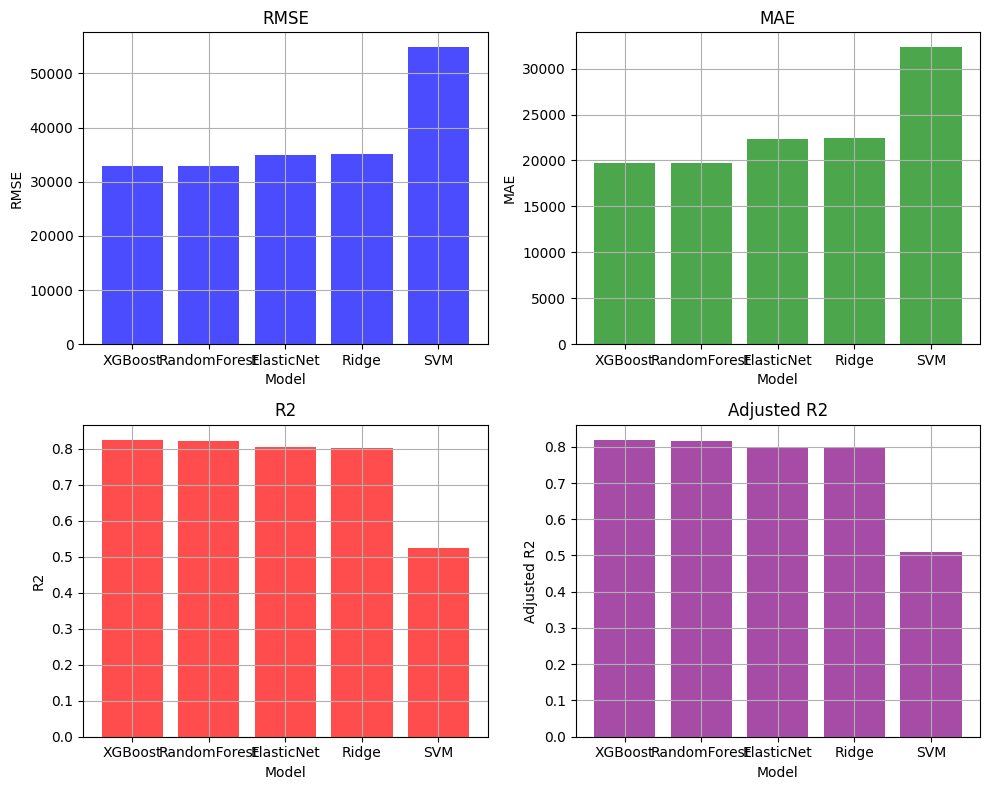

In [ ]:

# Initialize results dictionary
results_label = {"Model": [], "RMSE": [], "MAE": [], "R2": [], "Adjusted R2": []}

# Define k-fold cross-validation with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a function to calculate adjusted R^2
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# Define a custom scorer for GridSearchCV using mean squared error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Iterate over each model and its hyperparameter grid
for name, (model, params) in model_params.items():
    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(model, params, scoring=mse_scorer, cv=kf, n_jobs=-1)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Calculate mean squared error (MSE) using cross-validation and then RMSE
    mse = -cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=kf).mean()
    rmse = np.sqrt(mse)

    # Calculate mean absolute error (MAE) using cross-validation
    mae = cross_val_score(best_model, X, y, scoring='neg_mean_absolute_error', cv=kf).mean() * -1

    # Calculate R^2 using cross-validation
    r2 = cross_val_score(best_model, X, y, scoring='r2', cv=kf).mean()

    # Calculate the number of samples (n) and features (p)
    n, p = X.shape

    # Append the results to the dictionary
    results_label["Model"].append((name, best_model))
    results_label["RMSE"].append(rmse)
    results_label["MAE"].append(mae)
    results_label["R2"].append(r2)
    results_label["Adjusted R2"].append(adjusted_r2(r2, n, p))

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results_label)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
metrics = ["RMSE", "MAE", "R2", "Adjusted R2"]
colors = ['blue', 'green', 'red', 'purple']

# Iterate over each metric and create a bar plot
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    ax.bar([name for name, _ in results_df['Model']], results_df[metric], color=colors[i], alpha=0.7)
    ax.set_title(metric)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.grid(True)

# Adjust layout to prevent overlapping of plots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
results_label

{'Model': [('XGBoost',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=150, n_jobs=None,
                num_parallel_tree=None, random_state=42, ...)),
  ('RandomForest', RandomForestRegressor(n_estimators=200, random_state=42)),
  ('ElasticNet', ElasticNet(alpha=0.1, random_state=42)),
  ('Ridge', Ridge(alpha=10.0, random_state=42)),
  ('SVM', SVR(C=1

In [ ]:
# Using categorical features that all been Ordinally encoded or One hot encoded
final_scalar = StandardScaler()
X = final_scalar.fit_transform(np.hstack((features_pca[:, :k_dim], selected_categorical_features_df.values)))
y = train_df_non_categorical['SalePrice']



In [ ]:
X.shape

(1460, 70)

In [ ]:
# Define models and their hyperparameter grids
model_params = {
    "XGBoost": (XGBRegressor(random_state=42), {
        'n_estimators': [50, 75, 100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7]
    }),
    "RandomForest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 75,100, 75,200],
        'max_depth': [None, 10, 20]
    }),
    "ElasticNet": (ElasticNet(random_state=42), {
        'alpha': [0.1, 1.0, 5.0,10.0],
        'l1_ratio': [0.1, 0.5, 0.9]
    }),
    "Ridge": (Ridge(random_state=42), {
        'alpha': [0.1, 1.0, 5.0,10.0]
    }),
    "SVM": (SVR(), {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1.0, 5.0,10.0],
        'epsilon': [0.01, 0.1, 0.2]
    })
}

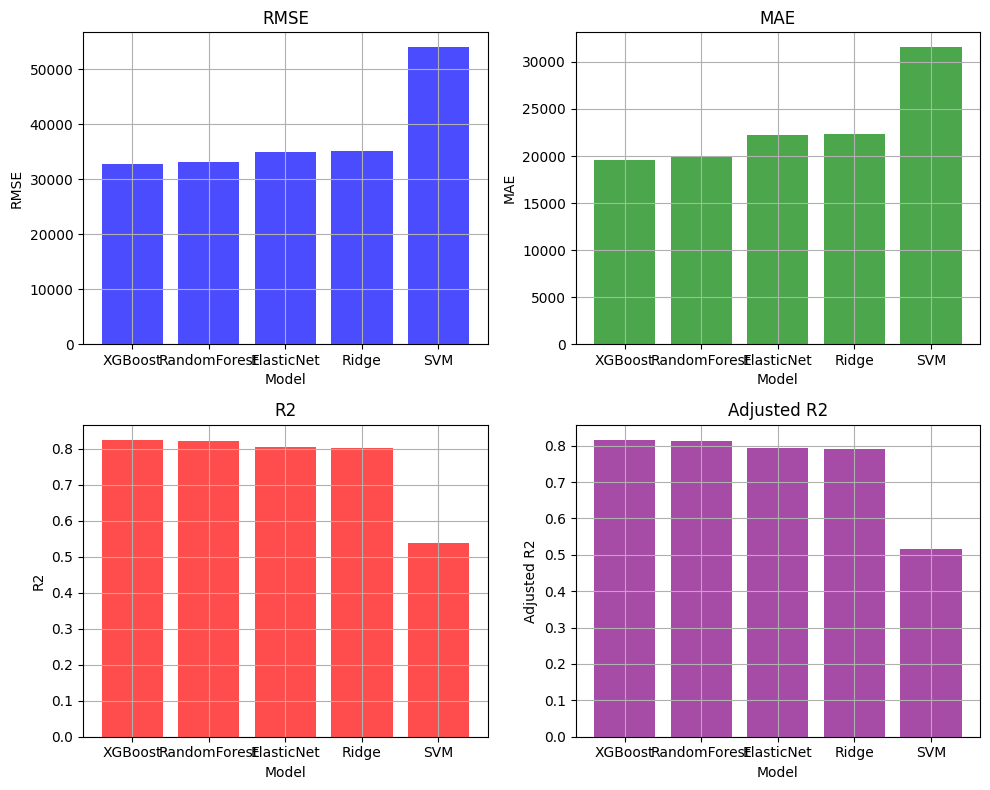

In [ ]:

# Initialize results dictionary
results = {"Model": [], "RMSE": [], "MAE": [], "R2": [], "Adjusted R2": []}

# Define k-fold cross-validation with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a function to calculate adjusted R^2
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# Define a custom scorer for GridSearchCV using mean squared error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Iterate over each model and its hyperparameter grid
for name, (model, params) in model_params.items():
    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(model, params, scoring=mse_scorer, cv=kf, n_jobs=-1)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Calculate mean squared error (MSE) using cross-validation and then RMSE
    mse = -cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=kf).mean()
    rmse = np.sqrt(mse)

    # Calculate mean absolute error (MAE) using cross-validation
    mae = cross_val_score(best_model, X, y, scoring='neg_mean_absolute_error', cv=kf).mean() * -1

    # Calculate R^2 using cross-validation
    r2 = cross_val_score(best_model, X, y, scoring='r2', cv=kf).mean()

    # Calculate the number of samples (n) and features (p)
    n, p = X.shape

    # Append the results to the dictionary
    results["Model"].append((name, best_model))
    results["RMSE"].append(rmse)
    results["MAE"].append(mae)
    results["R2"].append(r2)
    results["Adjusted R2"].append(adjusted_r2(r2, n, p))

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
metrics = ["RMSE", "MAE", "R2", "Adjusted R2"]
colors = ['blue', 'green', 'red', 'purple']

# Iterate over each metric and create a bar plot
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    ax.bar([name for name, _ in results_df['Model']], results_df[metric], color=colors[i], alpha=0.7)
    ax.set_title(metric)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.grid(True)

# Adjust layout to prevent overlapping of plots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
results

{'Model': [('XGBoost',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, random_state=42, ...)),
  ('RandomForest',
   RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)),
  ('ElasticNet', ElasticNet(alpha=0.1, random_state=42)),
  ('Ridge', Ridge(alpha=10.0, random_state=42)),


3. BaseLine Model (without feature extraction)

In [ ]:
# Make a copy of train_df
train_df_encoded = train_df.copy()

# Initialize LabelEncoder
label_encoders = {}

# Iterate over each column in train_df
for column in train_df_encoded.columns:
    # Check if the column is categorical
    if train_df_encoded[column].dtype == 'object':
        train_df_encoded[column].fillna("NA", inplace = True)
        # Initialize LabelEncoder for this column
        label_encoders[column] = LabelEncoder()
        # Fit LabelEncoder and transform the data
        train_df_encoded[column] = label_encoders[column].fit_transform(train_df_encoded[column])
    else:
        train_df_encoded[column].fillna(train_df_encoded[column].mean(), inplace = True)




X = StandardScaler().fit_transform(train_df_encoded.drop(['Id', 'SalePrice'], axis = 1))
y = train_df_encoded['SalePrice']

In [ ]:
# Define models and their hyperparameter grids
model_params = {
    "XGBoost": (XGBRegressor(random_state=42), {
        'n_estimators': [50, 75, 100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7]
    }),
    "RandomForest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 75,100, 75,200],
        'max_depth': [None, 10, 20]
    }),
    "ElasticNet": (ElasticNet(random_state=42), {
        'alpha': [0.1, 1.0, 5.0,10.0],
        'l1_ratio': [0.1, 0.5, 0.9]
    }),
    "Ridge": (Ridge(random_state=42), {
        'alpha': [0.1, 1.0, 5.0,10.0]
    }),
    "SVM": (SVR(), {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1.0, 5.0,10.0],
        'epsilon': [0.01, 0.1, 0.2]
    })
}

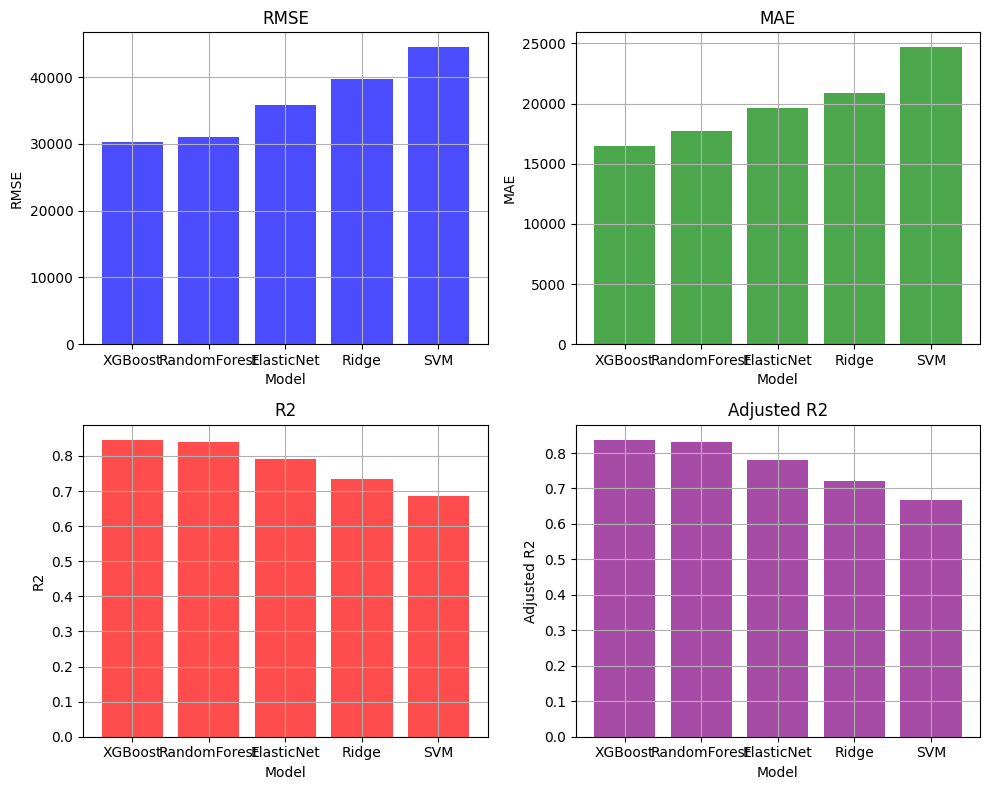

<Figure size 640x480 with 0 Axes>

In [ ]:

# Initialize results dictionary
# Initialize an empty dictionary to store the results
results_baseline = {"Model": [], "RMSE": [], "MAE": [], "R2": [], "Adjusted R2": []}

# Define k-fold cross-validation with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a function to calculate adjusted R^2
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# Define a custom scorer for GridSearchCV using mean squared error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Iterate over each model and its hyperparameter grid
for name, (model, params) in model_params.items():
    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(model, params, scoring=mse_scorer, cv=kf, n_jobs=-1)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Calculate mean squared error (MSE) using cross-validation
    mse = -cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=kf).mean()
    mae = cross_val_score(best_model, X, y, scoring='neg_mean_absolute_error', cv=kf).mean() * -1
    rmse = np.sqrt(mse)

    # Calculate R^2 using cross-validation
    r2 = cross_val_score(best_model, X, y, scoring='r2', cv=kf).mean()

    # Calculate the number of samples (n) and features (p)
    n, p = X.shape

    # Append the results to the dictionary
    results_baseline["Model"].append(name)
    results_baseline["RMSE"].append(rmse)
    results_baseline["MAE"].append(mae)
    results_baseline["R2"].append(r2)
    results_baseline["Adjusted R2"].append(adjusted_r2(r2, n, p))

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results_baseline)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
metrics = ["RMSE", "MAE", "R2", "Adjusted R2"]
colors = ['blue', 'green', 'red', 'purple']

# Iterate over each metric and create a bar plot
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    ax.bar(results_df['Model'], results_df[metric], color=colors[i], alpha=0.7)
    ax.set_title(metric)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.grid(True)


# Adjust layout to prevent overlapping of plots
plt.tight_layout()

# Show the plots
plt.show()
plt.tight_layout()
plt.show()


In [ ]:
results_baseline

{'Model': ['XGBoost', 'RandomForest', 'ElasticNet', 'Ridge', 'SVM'],
 'RMSE': [30363.766295588935,
  31018.23122696187,
  35785.36195628457,
  39807.3751887264,
  44501.70453151273],
 'MAE': [16495.03186536815,
  17738.716565197326,
  19626.35271875491,
  20884.380795138808,
  24692.558004821287],
 'R2': [0.8463574505422301,
  0.8409636838262651,
  0.7919596326723884,
  0.7353006252781449,
  0.686176814728257],
 'Adjusted R2': [0.8375619712616766,
  0.8318594309438556,
  0.7800500754123295,
  0.7201475451310242,
  0.6682115744119761]}

## Test data

In [ ]:
final_scalar = StandardScaler()

In [ ]:
final_scalar = StandardScaler()
X_test = final_scalar.fit_transform(np.hstack(
    (pca.transform(StandardScaler().fit_transform(test_df_continuous_selected))[:,:k_dim],
     selected_categorical_features_df_test.values)
    ))

In [ ]:
X_test.shape

(1459, 70)

In [ ]:
xg_boost_model = results['Model'][0][1]

predicted_values = xg_boost_model.predict(X_test)

In [ ]:
# Create a DataFrame with Id and SalePrice
submission_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predicted_values
})

# Write the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)